Submitted by:
Maham Waseem (27257)


# Final Project

Importing the required dependencies

In [1]:

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from scipy.stats import chi2_contingency
from sklearn.feature_selection import f_classif
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

Creating Functions
</br>
1-LoadData </br>
2-CleanFun </br>
3-KYFS </br>
4-FTRsclt </br>
5-PCAViz </br>
6-ClusterFun </br>
7-VizFun </br>

1. LoadData

In [2]:
import chardet
import pandas as pd

def LoadData(Loc):
    # Read the raw data to detect encoding
    rawdata = open(Loc, 'rb').read()
    result = chardet.detect(rawdata)

    # Read the CSV file using the detected encoding
    data = pd.read_csv(Loc, encoding=result['encoding'])

    return data



Noise Removal Function

In [3]:
import pandas as pd

def remove_outliers_iqr(data):
    # Copy the data to avoid modifying the original data
    clean_data = data.copy()

    # Loop through each column in the data
    for column in clean_data.select_dtypes(include=['float64', 'int64']).columns:  # Only numeric columns
        Q1 = clean_data[column].quantile(0.25)  # 1st quartile
        Q3 = clean_data[column].quantile(0.75)  # 3rd quartile
        IQR = Q3 - Q1  # Interquartile Range

        # Calculate the lower and upper bounds for outliers
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Filter the data to remove outliers
        clean_data = clean_data[(clean_data[column] >= lower_bound) & (clean_data[column] <= upper_bound)]

    return clean_data


2. CleanFun

In [4]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
import pandas as pd
import numpy as np


def CleanData(df):
    """
    Generalized function to clean a dataset with categorical, integer, binary, continuous, and boolean data types.
    - Automatically handles missing values, encodes categorical data, and scales continuous and integer data.

    Parameters:
    - df: The input DataFrame.

    Returns:
    - df_cleaned: The cleaned and transformed DataFrame.
    """

    # Step 1: Handle special missing value representations ("?" in this dataset)
    df.replace('?', np.nan, inplace=True)

    # Replace blank strings with NaN in the DataFrame
    df.replace('', np.nan, inplace=True)

    # Step 2: Detect column types
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
    continuous_cols = df.select_dtypes(include=['float64', 'float32']).columns.tolist()
    integer_cols = df.select_dtypes(include=['int64', 'int32']).columns.tolist()

    # Detect binary columns (those with exactly 2 unique values)
    binary_cols = [col for col in df.columns if df[col].nunique() == 2]

    # Detect boolean columns
    boolean_cols = df.select_dtypes(include=['bool']).columns.tolist()

    # Convert boolean columns to integers (0 and 1)
    df[boolean_cols] = df[boolean_cols].astype(int)

    # Remove binary and boolean columns from integer cols since they are handled separately
    integer_cols = [col for col in integer_cols if col not in binary_cols + boolean_cols]

    # Step 3: Handle missing values
    # Fill missing continuous values with the mean
    if continuous_cols:
        imputer_cont = SimpleImputer(strategy='mean')
        df[continuous_cols] = imputer_cont.fit_transform(df[continuous_cols])

    # Fill missing integer values with the median
    if integer_cols:
        imputer_int = SimpleImputer(strategy='median')
        df[integer_cols] = imputer_int.fit_transform(df[integer_cols])

    # Fill missing categorical values with the most frequent value (mode)
    if categorical_cols:
        imputer_cat = SimpleImputer(strategy='most_frequent')
        df[categorical_cols] = imputer_cat.fit_transform(df[categorical_cols])

    # Fill missing binary values with the mode
    if binary_cols:
        imputer_bin = SimpleImputer(strategy='most_frequent')
        df[binary_cols] = imputer_bin.fit_transform(df[binary_cols])

    # Step 4: Encode categorical variables (One-hot encoding)
    # Drop blanks that may have persisted and apply encoding
    df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

    # Step 5: Scale continuous and integer variables
    scaler = StandardScaler()
    if continuous_cols:
        df_encoded[continuous_cols] = scaler.fit_transform(df_encoded[continuous_cols])
    if integer_cols:
        df_encoded[integer_cols] = scaler.fit_transform(df_encoded[integer_cols])

    return df_encoded


In [5]:

def list_columns_with_missing_values(df):
    result=df.isnull().sum(0)
    return result


def drop_null(df): #This function will clean the dataset by dropping null values.
    df.dropna(inplace=True)
    return(df)


def fill_null_mean(df):

    df_float = df.select_dtypes(include='float64').columns.tolist()
    # Make a copy of float columns
    X = df[df_float].copy()

    # Calculate means of each column
    means = X.mean()

    # Fill missing values with mean values
    X.fillna(value=means, inplace=True)

    # Assign the filled float columns back to the original DataFrame
    df[df_float] = X

    return df



def CleanFun(data): #This function will clean the dataset.

    print("Number of missing values in your data set:",list_columns_with_missing_values(data))

    print("Number of duplicate rows in your data set:",data.duplicated().sum())
    print("All the missing values have been filled wtih mean values")
    print("All the duplicate rows have been deleted from data set")


    data.drop_duplicates(inplace=True)
    data = fill_null_mean(data)
    return(data)




In [6]:
import pandas as pd
import numpy as np

# Function to replace NaN with mode and print unique values
def replace_nan_with_mode_and_print(df, columns):
    for column in columns:
        # Calculate the mode of the column
        mode_value = df[column].mode()[0]  # Select the first mode value
        # Replace NaN values with mode
        df[column] = df[column].fillna(mode_value)

        # Print the unique values after filling NaN
        print(f"Unique values in column '{column}': {df[column].unique()}")

    return df


In [7]:
import pandas as pd

def retain_numeric_values(df, columns):
    """
    Retains only numeric or float values in the specified columns and replaces all other entries with blank strings.
    Leaves other columns blank.

    Parameters:
    df (DataFrame): The pandas DataFrame to operate on.
    columns (list): List of column names to retain numeric values in.

    Returns:
    DataFrame: Updated DataFrame with only numeric values retained in the specified columns and other columns left blank.
    """
    # Create a new DataFrame to store the result
    new_df = pd.DataFrame(index=df.index, columns=df.columns)

    for col in columns:
        if col in df.columns:
            # Retain numeric values; replace others with blank
            new_df[col] = df[col].apply(lambda x: x if isinstance(x, (int, float)) else "")
        else:
            print(f"Warning: Column '{col}' does not exist in the DataFrame.")

    return new_df


3. KYFS

In [8]:
def KYFS(df):

    desc = pd.DataFrame(index = list(df))
    desc['type'] = df.dtypes
    desc['count'] = df.count()
    desc['nunique'] = df.nunique()
    desc['%unique'] = desc['nunique'] / len(df) * 100
    desc['null'] = df.isnull().sum()
    desc['%null'] = desc['null'] / len(df) * 100
    desc['min'] = df.min()
    desc['max'] = df.max()
    return desc;

In [9]:
import pandas as pd

def print_column_names(data):
    """
    Prints the names of all columns in the given DataFrame.

    Parameters:
    data (pd.DataFrame): The input DataFrame.
    """
    print("Column Names:")
    for column in data.columns:
        print(column)


In [10]:
import pandas as pd

def get_unique_entities(df, column_name):
    """
    Fetch and display unique entities in a specified column of the DataFrame.

    Parameters:
    df (pd.DataFrame): The input DataFrame.
    column_name (str): The name of the column to inspect for unique values.

    Returns:
    list: A list of unique values in the specified column.
    """
    if column_name in df.columns:
        unique_values = df[column_name].unique()
        print(f"Unique values in column '{column_name}':")
        print(unique_values)
        return unique_values
    else:
        print(f"Column '{column_name}' does not exist in the DataFrame.")
        return []



In [11]:
def ViewColumnTypes(df):
    """
    View which columns are categorical, continuous, integer, and binary.

    Parameters:
    - df: The input DataFrame.

    Returns:
    - A dictionary containing column names categorized by type.
    """
    # Step 1: Get columns by data types
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
    continuous_cols = df.select_dtypes(include=['float64', 'float32']).columns.tolist()
    integer_cols = df.select_dtypes(include=['int64', 'int32']).columns.tolist()

    # Step 2: Identify binary columns (those with exactly two unique values)
    binary_cols = [col for col in df.columns if df[col].nunique() == 2]

    # Print the results
    print(f"Categorical Columns: {categorical_cols}")
    print(f"Continuous Columns: {continuous_cols}")
    print(f"Integer Columns: {integer_cols}")
    print(f"Binary Columns: {binary_cols}")

    # Return the results in a dictionary (for potential future use)
    return {
        "categorical_cols": categorical_cols,
        "continuous_cols": continuous_cols,
        "integer_cols": integer_cols,
        "binary_cols": binary_cols
    }


Encoding Function

In [12]:
import pandas as pd

def one_hot_encode_columns(data, columns):
    """
    Performs one-hot encoding on specified categorical columns in a DataFrame.

    Parameters:
    data (pd.DataFrame): The input DataFrame.
    columns (list): List of column names to one-hot encode.

    Returns:
    pd.DataFrame: DataFrame with one-hot encoded columns.
    """
    for column in columns:
        if column in data.columns:
            print(f"One-hot encoding column: {column}")

            # Create one-hot encoded DataFrame for the column
            one_hot = pd.get_dummies(data[column], prefix=column)

            # Drop the original column and concatenate the new one-hot columns
            data = pd.concat([data.drop(column, axis=1), one_hot], axis=1)
        else:
            raise KeyError(f"Column '{column}' does not exist in the DataFrame.")

    return data


In [13]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd

def encode_categorical_columns(data, columns):
    """
    Encodes the specified categorical columns in a DataFrame using LabelEncoder.

    Parameters:
    data (pd.DataFrame): The input DataFrame.
    columns (list): List of column names to encode.

    Returns:
    pd.DataFrame: DataFrame with encoded columns.
    """
    # Initialize the LabelEncoder
    label_encoder = LabelEncoder()

    # Loop through the specified columns and encode them
    for column in columns:
        if column in data.columns:
            data[column] = label_encoder.fit_transform(data[column])
        else:
            raise KeyError(f"Column '{column}' does not exist in the DataFrame.")

    return data


4. FTRsclt

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler


def FtrSlct(df, hist_color='maroon', boxplot_color='maroon'):
    """
    Function to display:
    1. Summary statistics styled for numerical features.
    2. Histograms and boxplots for all numerical features.
    3. Correlation heatmap for all numerical features.
    4. Histograms and boxplots for scaled features to check for normalization.

    Args:
        df (pd.DataFrame): Input DataFrame.
        hist_color (str): Color for histograms.
        boxplot_color (str): Color for boxplots.
    """

    # Separating numerical features
    numeric_features = df.select_dtypes(include=['float64'])  # Select only float64 columns

    # Summary statistics with styled properties
    summary_stats = numeric_features.describe().style.set_properties(**{
        'color': 'maroon',
        'text-align': 'center',
        'font-weight': 'bold'
    })
    print("\n\033[1m\033[91mSummary Statistics:\033[0m")
    display(summary_stats)

    # Standard scaling of features to range [0, 1]
    scaler = MinMaxScaler()
    scaled_features = pd.DataFrame(scaler.fit_transform(numeric_features), columns=numeric_features.columns)

    # Calculate number of rows required to plot the visualizations
    num_cols = len(numeric_features.columns)
    num_rows = (num_cols - 1) // 3 + 1  # Rows needed for visualization grid

    # Plotting histograms and boxplots for original features
    fig, axes = plt.subplots(nrows=num_rows * 2, ncols=3, figsize=(16, 5 * num_rows))

    for i, column in enumerate(numeric_features.columns):
        row = i // 3  # Determine row index
        col = i % 3  # Determine column index

        # Histogram for original data
        sns.histplot(df[column], bins=20, kde=True, color=hist_color, ax=axes[row * 2, col])
        axes[row * 2, col].set_title(f'Histogram of {column}')
        axes[row * 2, col].set_xlabel(column)
        axes[row * 2, col].set_ylabel('Frequency')

        # Boxplot for original data
        sns.boxplot(data=df, y=column, color=boxplot_color, ax=axes[row * 2 + 1, col])
        axes[row * 2 + 1, col].set_title(f'Boxplot of {column}')
        axes[row * 2 + 1, col].set_ylabel(column)

    plt.tight_layout()
    plt.show()

    # Plotting histograms and boxplots for scaled features
    fig, axes = plt.subplots(nrows=num_rows * 2, ncols=3, figsize=(16, 5 * num_rows))

    for i, column in enumerate(scaled_features.columns):
        row = i // 3  # Determine row index
        col = i % 3  # Determine column index

        # Histogram for scaled data
        sns.histplot(scaled_features[column], bins=20, kde=True, color=hist_color, ax=axes[row * 2, col])
        axes[row * 2, col].set_title(f'Scaled Histogram of {column}')
        axes[row * 2, col].set_xlabel(column)
        axes[row * 2, col].set_ylabel('Frequency')

        # Boxplot for scaled data
        sns.boxplot(data=scaled_features, y=column, color=boxplot_color, ax=axes[row * 2 + 1, col])
        axes[row * 2 + 1, col].set_title(f'Scaled Boxplot of {column}')
        axes[row * 2 + 1, col].set_ylabel(column)

    plt.tight_layout()
    plt.show()

    # Correlation matrix
    correlation_matrix = numeric_features.corr()  # Calculate correlation matrix

    # Heatmap of correlations
    plt.figure(figsize=(12, 10))  # Adjust heatmap size as needed
    sns.heatmap(correlation_matrix, cmap="coolwarm", annot=True, fmt=".2f", linewidths=1)
    plt.title('Correlation Heatmap')
    plt.xlabel('Variables')
    plt.ylabel('Variables')
    plt.show()


In [15]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler


def drop_highly_correlated_and_scale(data, threshold=0.8):
    """
    Drop columns from a DataFrame based on high correlation between columns
    and scale only float columns to a [0, 1] range using standard MinMax scaling.

    Parameters:
    - data: DataFrame
    - threshold: Correlation threshold to identify highly correlated columns (default=0.8)

    Returns:
    - DataFrame with highly correlated columns removed and scaled to range 0-1
    """
    # Step 1: Filter only float columns
    float_data = data.select_dtypes(include=[float])

    # Step 2: Calculate the correlation matrix for only float columns
    corr_matrix = float_data.corr().abs()

    # Step 3: Identify columns to drop (those with correlations above the threshold)
    upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > threshold)]

    print(f"Columns to drop: {to_drop}")

    # Step 4: Drop the highly correlated columns from only float columns
    df_reduced = float_data.drop(columns=to_drop)

    # Step 5: Scale the remaining float columns from 0 to 1 using MinMaxScaler
    scaler = MinMaxScaler()
    df_reduced[df_reduced.columns] = scaler.fit_transform(df_reduced)

    return df_reduced


# Example usage:
# Assuming `data_1` is your original DataFrame
# result = drop_highly_correlated_and_scale(data_1, threshold=0.6)


Normalization

In [16]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Function to normalize data and show new ranges
def normalize_data(dataframe):
    # Ensure the dataframe is a pandas DataFrame
    if not isinstance(dataframe, pd.DataFrame):
        raise ValueError("Input should be a pandas DataFrame.")

    # Initialize the MinMaxScaler
    scaler = MinMaxScaler()

    # Apply Min-Max scaling to all columns (assuming numerical data)
    normalized_data = scaler.fit_transform(dataframe)

    # Create a DataFrame with normalized values
    normalized_df = pd.DataFrame(normalized_data, columns=dataframe.columns)

    # Display the new ranges of individual features
    new_ranges = normalized_df.min(), normalized_df.max()
    print("New Ranges of the Features:")
    for feature, (min_val, max_val) in zip(normalized_df.columns, zip(new_ranges[0], new_ranges[1])):
        print(f"{feature}: Min = {min_val}, Max = {max_val}")

    return normalized_df


To Learn the optimum numbers of clusters for K-Means

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.datasets import make_blobs


def kmeans_within_cluster_sum_of_squares(X, n_clusters):
    """Calculate W_k, which is the within-cluster sum of squares for KMeans."""
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(X)
    return kmeans.inertia_  # inertia_ is the within-cluster sum of squares


def generate_random_reference_data(X, n_references=10):
    """Generate random datasets with the same shape and range as X."""
    min_X, max_X = np.min(X, axis=0), np.max(X, axis=0)
    random_datasets = [np.random.uniform(min_X, max_X, X.shape) for _ in range(n_references)]
    return random_datasets


def compute_gap_statistic(X, max_clusters=10, n_references=10):
    """Compute the Gap Statistic for a range of clusters."""
    gaps = []
    Wks = []  # Wk for original data
    Wk_refs = []  # Wk for reference datasets

    # Loop over each number of clusters
    for k in range(1, max_clusters + 1):
        # Calculate Wk for the original data
        Wk = kmeans_within_cluster_sum_of_squares(X, k)
        Wks.append(np.log(Wk))

        # Generate reference datasets and compute their Wk
        reference_wk = []
        for reference_data in generate_random_reference_data(X, n_references):
            ref_wk = kmeans_within_cluster_sum_of_squares(reference_data, k)
            reference_wk.append(np.log(ref_wk))

        # Compute the gap statistic
        Wk_ref_mean = np.mean(reference_wk)
        gap = Wk_ref_mean - np.log(Wk)
        gaps.append(gap)
        Wk_refs.append(Wk_ref_mean)

    # Return the gap values and Wk for plotting or analysis
    return np.array(gaps), np.array(Wks), np.array(Wk_refs)


def gapstat(data):  # Compute the gap statistic for clusters from 1 to 10
    max_clusters = 10
    gaps, Wks, Wk_refs = compute_gap_statistic(data, max_clusters=max_clusters)

    # Find the optimal number of clusters based on maximum gap value
    optimal_clusters = np.argmax(gaps) + 1  # +1 to adjust index offset

    # Plot the Gap Statistic
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, max_clusters + 1), gaps, marker='o', linestyle='-', color='b', label='Gap Statistic')

    # Highlight the optimal number of clusters
    plt.axvline(x=optimal_clusters, color='r', linestyle='--', label=f'Optimal clusters: {optimal_clusters}')
    plt.scatter(optimal_clusters, gaps[optimal_clusters - 1], color='red', s=100, zorder=5)  # Mark the point
    plt.annotate(
        f"Optimal k={optimal_clusters}",
        (optimal_clusters, gaps[optimal_clusters - 1]),
        textcoords="offset points",
        xytext=(0, 5),
        ha='center',
        fontsize=10
    )

    plt.title("Gap Statistic to Determine Optimal Number of Clusters")
    plt.xlabel("Number of clusters (k)")
    plt.ylabel("Gap Statistic")
    plt.legend()
    plt.grid()
    plt.show()

    # Print optimal number of clusters
    print(f"Optimal number of clusters detected: {optimal_clusters}")

    return optimal_clusters


In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import warnings

warnings.filterwarnings("ignore", category=UserWarning, module='sklearn.cluster._kmeans')


def calculate_wcss(data):
    """
    Computes the WCSS for different numbers of clusters after normalizing the data
    to the 0-1 range to help determine the optimal number of clusters.

    Parameters:
    - data: 2D numpy array or pandas DataFrame

    Returns:
    - List of WCSS values for each number of clusters.
    """
    # Normalize the data to a 0-1 range
    scaler = MinMaxScaler()
    data_normalized = scaler.fit_transform(data)

    # Calculate WCSS values for clusters ranging from 1 to 10
    wcss = []
    for i in range(1, 11):
        kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
        kmeans.fit(data_normalized)
        wcss.append(kmeans.inertia_)

    return wcss


def find_optimal_clusters(wcss):
    """
    Determines the optimal number of clusters by finding the 'elbow' point.

    Heuristic: The elbow point is where the rate of reduction in WCSS starts slowing down.
    We'll calculate the differences to find this point.

    Parameters:
    - wcss: List of computed WCSS values

    Returns:
    - The number of clusters at the elbow point.
    """
    # Calculate the first and second derivatives of WCSS values to find the "elbow"
    deltas = np.diff(wcss)  # First difference
    deltas_diff = np.diff(deltas)  # Second difference to detect slowing rate

    # The elbow point corresponds to the index where the change minimizes
    optimal_clusters = np.argmin(deltas_diff) + 2  # +2 to map indices correctly
    return optimal_clusters


K-means Clustering

In [19]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import pdist

def cluster_and_map_labels(dataset, n_clusters):
    """
    Performs K-means and Hierarchical clustering on the dataset, maps labels to it,
    and returns two datasets with K-means and Hierarchical labels, respectively.

    Parameters:
        dataset (pd.DataFrame): Original dataset.
        n_clusters (int): Number of clusters.

    Returns:
        pd.DataFrame: Dataset with K-means labels.
        pd.DataFrame: Dataset with Hierarchical labels.
    """
    # Ensure only numeric columns are used for clustering
    numeric_data = dataset.select_dtypes(include=[np.number])

    # K-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans_labels = kmeans.fit_predict(numeric_data)

    # Hierarchical clustering (Ward linkage with Euclidean distance)
    distance_matrix = pdist(numeric_data, metric='euclidean')
    hierarchical = linkage(distance_matrix, method='ward')
    hierarchical_labels = fcluster(hierarchical, t=n_clusters, criterion='maxclust')

    # Map labels to original dataset
    kmeans_dataset = dataset.copy()
    hierarchical_dataset = dataset.copy()
    kmeans_dataset['KMeans_Labels'] = kmeans_labels
    hierarchical_dataset['Hierarchical_Labels'] = hierarchical_labels

    return kmeans_dataset, hierarchical_dataset

# Example Usage:
# Assuming `df` is your original dataset and you want 3 clusters:
# kmeans_df, hierarchical_df = cluster_and_map_labels(df, n_clusters=3)

# Save or process the resulting datasets
# kmeans_df.to_csv('kmeans_output.csv', index=False)
# hierarchical_df.to_csv('hierarchical_output.csv', index=False)


Code for Silhoutescores

In [ ]:
# Calculate Silhouette Score
#sil_score = silhouette_score(df, labels)
#print(f"Silhouette Score: {sil_score}")

Calculate DBI

In [ ]:

# Compute Davies-Bouldin Index
# dbi = davies_bouldin_score(df, labels)
# print(f"Davies-Bouldin Index: {dbi}")

Now for K-Prototype

In [20]:
!pip install kmodes


In [21]:
import pandas as pd
import numpy as np
from kmodes.kprototypes import KPrototypes
from scipy.spatial.distance import pdist


def cluster_and_map_labels(dataset, n_clusters):
    """
    Performs K-Prototypes clustering on the mixed-type dataset and maps labels to it.

    Parameters:
        dataset (pd.DataFrame): Original dataset with mixed-type features (categorical + numerical).
        n_clusters (int): Number of clusters.

    Returns:
        pd.DataFrame: Dataset with KPrototypes clustering labels.
    """
    # Identify continuous and categorical features
    continuous_variables = dataset.select_dtypes(include=['float64', 'int64']).columns.tolist()
    categorical_variables = dataset.select_dtypes(include=['object']).columns.tolist()

    # Handle missing values in the input data
    kmodes_input_data = pd.concat([dataset[continuous_variables], dataset[categorical_variables]], axis=1).fillna(0)

    # Map categorical indices to subset's column indices only
    categorical_indices = [dataset.columns.get_loc(col) for col in categorical_variables]

    # Map these indices to relative positions in `kmodes_input_data`
    # Fix index misalignment by converting them to the local subset's indices
    adjusted_categorical_indices = [continuous_variables.index(col) if col in continuous_variables else len(continuous_variables) + categorical_variables.index(col) for col in categorical_variables]

    # Initialize KPrototypes clustering
    kproto = KPrototypes(n_clusters=n_clusters, random_state=42)

    # Perform clustering
    cluster_labels = kproto.fit_predict(
        kmodes_input_data, categorical=adjusted_categorical_indices
    )

    # Map the clustering results to the original dataset
    clustered_dataset = dataset.copy()
    clustered_dataset['KPrototypes_Labels'] = cluster_labels

    return clustered_dataset


# Example Usage:
# Assuming `data` is your DataFrame with mixed types
#clustered_df = cluster_and_map_labels(data, n_clusters=3)

# Save or process the resulting datasets
# clustered_df.to_csv('kprototypes_output.csv', index=False)


TSNE Visualization

In [22]:
def visualize_tsne_clusters(kmeans_dataset, hierarchical_dataset):
    """
    Visualizes KMeans and Hierarchical clustering using t-SNE in a side-by-side comparison.

    Parameters:
        kmeans_dataset (pd.DataFrame): Data with KMeans labels.
        hierarchical_dataset (pd.DataFrame): Data with Hierarchical clustering labels.
    """
    from sklearn.manifold import TSNE
    import matplotlib.pyplot as plt

    # Perform t-SNE on KMeans clustering data
    tsne = TSNE(n_components=2, random_state=42)
    kmeans_2d = tsne.fit_transform(kmeans_dataset.select_dtypes(include=[np.number]).drop(columns='KMeans_Labels'))

    # Perform t-SNE on Hierarchical clustering data
    hierarchical_2d = tsne.fit_transform(hierarchical_dataset.select_dtypes(include=[np.number]).drop(columns='Hierarchical_Labels'))

    # Create side-by-side scatter plots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))

    # KMeans scatter
    scatter1 = ax1.scatter(
        kmeans_2d[:, 0],
        kmeans_2d[:, 1],
        c=kmeans_dataset['KMeans_Labels'],
        cmap='viridis',
        s=100,
        edgecolor='k'
    )
    ax1.set_title("KMeans Clustering (t-SNE)")
    ax1.set_xlabel("t-SNE 1")
    ax1.set_ylabel("t-SNE 2")
    legend1 = ax1.legend(*scatter1.legend_elements(), title="Cluster")
    ax1.add_artist(legend1)

    # Hierarchical scatter
    scatter2 = ax2.scatter(
        hierarchical_2d[:, 0],
        hierarchical_2d[:, 1],
        c=hierarchical_dataset['Hierarchical_Labels'],
        cmap='viridis',
        s=100,
        edgecolor='k'
    )
    ax2.set_title("Hierarchical Clustering (t-SNE)")
    ax2.set_xlabel("t-SNE 1")
    ax2.set_ylabel("t-SNE 2")
    legend2 = ax2.legend(*scatter2.legend_elements(), title="Cluster")
    ax2.add_artist(legend2)

    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()


Radarplot clustering

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from math import pi


def plot_radar(label_column_name, clustered_df, ax):
    """
    Function to generate radar chart based on cluster averages and features.

    Parameters:
    - label_column_name: Name of the column containing cluster labels (e.g., 'KMeans_Cluster').
    - clustered_df: DataFrame that contains features and clustering labels.
    - ax: The matplotlib axis object to plot the radar chart on.
    """
    # Extract the feature columns dynamically (exclude the label column)
    feature_cols = [col for col in clustered_df.columns if col != label_column_name]

    # Group by clustering labels and compute the mean of feature values per group
    grouped = clustered_df.groupby(label_column_name)[feature_cols].mean().reset_index()

    # Number of features for plotting
    categories = feature_cols
    N = len(categories)

    # Compute the number of axes required for radar plots
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles.append(angles[0])  # Close the radar plot loop by repeating the first angle

    # Loop through clusters and plot each one
    for index, row in grouped.iterrows():
        # Prepare data for radar plot
        values = row[1:].values.flatten().tolist()
        values.append(values[0])  # Close the radar plot loop by repeating the first value
        ax.plot(angles, values, label=f"Cluster {row[label_column_name]}")
        ax.fill(angles, values, alpha=0.25)  # Fill the area under the radar chart

    # Set axis labels
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories)

    # Add legend and title
    ax.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))
    ax.set_title(f"Radar Plot for {label_column_name}", size=15, pad=20)


# Compare two datasets side-by-side
def compare_datasets(dataset1, label1, dataset2, label2):
    """
    Function to compare two datasets side-by-side using radar plots.

    Parameters:
    - dataset1: The first DataFrame.
    - label1: Label column name for the first dataset.
    - dataset2: The second DataFrame.
    - label2: Label column name for the second dataset.
    """
    # Set up the side-by-side plots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7), subplot_kw=dict(polar=True))

    # Plot the first radar chart
    plot_radar(label1, dataset1, ax1)

    # Plot the second radar chart
    plot_radar(label2, dataset2, ax2)

    # Show the comparison side-by-side
    plt.tight_layout()
    plt.show()


for single Visualization

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from math import pi


def plot_radar(label_column_name, clustered_df, ax):
    """
    Function to generate radar chart based on cluster averages and features.

    Parameters:
    - label_column_name: Name of the column containing cluster labels (e.g., 'KMeans_Cluster').
    - clustered_df: DataFrame that contains features and clustering labels.
    - ax: The matplotlib axis object to plot the radar chart on.
    """
    # Extract the feature columns dynamically (exclude the label column)
    feature_cols = [col for col in clustered_df.columns if col != label_column_name]

    # Group by clustering labels and compute the mean of feature values per group
    grouped = clustered_df.groupby(label_column_name)[feature_cols].mean().reset_index()

    # Number of features for plotting
    categories = feature_cols
    N = len(categories)

    # Compute the number of axes required for radar plots
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles.append(angles[0])  # Close the radar plot loop by repeating the first angle

    # Loop through clusters and plot each one
    for index, row in grouped.iterrows():
        # Prepare data for radar plot
        values = row[1:].values.flatten().tolist()
        values.append(values[0])  # Close the radar plot loop by repeating the first value
        ax.plot(angles, values, label=f"Cluster {row[label_column_name]}")
        ax.fill(angles, values, alpha=0.25)  # Fill the area under the radar chart

    # Set the axis labels
    ax.set_xticks(angles[:-1])  # Set ticks for each axis except the last repeated
    ax.set_xticklabels(categories)

    # Add legend
    ax.legend()


Master Function

In [25]:
data=LoadData(r'/content/Telco_customer_churn.csv')

In [26]:
import pandas as pd
import numpy as np


# Function to replace NaN with mode and print the unique values across the entire DataFrame
def replace_nan_with_mode_and_print_all_unique(df, columns):
    for column in columns:
        # Calculate the mode of the column
        mode_value = df[column].mode()[0]  # Select the first mode value
        # Replace NaN values with mode
        df[column] = df[column].fillna(mode_value)

    # Print all unique values in the entire DataFrame
    all_unique_values = df.apply(lambda x: x.unique()).explode().unique()
    print(f"\nAll unique values across the entire DataFrame: {all_unique_values}")

    return df


# Columns to process
columns_to_replace = [
    'Churn Reason','Total Charges'
]

# Apply the function
data = replace_nan_with_mode_and_print_all_unique(data, columns_to_replace)

# Display the updated DataFrame
print("\nUpdated DataFrame:")



All unique values across the entire DataFrame: ['3668-QPYBK' '9237-HQITU' '9305-CDSKC' ... 'Attitude of service provider'
 'Attitude of support person' 'Deceased']

Updated DataFrame:


In [27]:
data=CleanFun(data)

Number of missing values in your data set: CustomerID           0
Count                0
Country              0
State                0
City                 0
Zip Code             0
Lat Long             0
Latitude             0
Longitude            0
Gender               0
Senior Citizen       0
Partner              0
Dependents           0
Tenure Months        0
Phone Service        0
Multiple Lines       0
Internet Service     0
Online Security      0
Online Backup        0
Device Protection    0
Tech Support         0
Streaming TV         0
Streaming Movies     0
Contract             0
Paperless Billing    0
Payment Method       0
Monthly Charges      0
Total Charges        0
Churn Value          0
Churn Score          0
CLTV                 0
Churn Reason         0
dtype: int64
Number of duplicate rows in your data set: 0
All the missing values have been filled wtih mean values
All the duplicate rows have been deleted from data set


In [28]:
data.shape

(7043, 32)

In [29]:
# Safely convert 'Churn Reason' to string
data['Churn Reason'] = data['Churn Reason'].astype(str)

# Safely convert 'Total Charges' to float, handling errors
data['Total Charges'] = pd.to_numeric(data['Total Charges'], errors='coerce')


In [30]:
import pandas as pd

def find_problematic_features(df):
    problematic_features = []

    for col in df.columns:
        try:
            # Attempt to compute min and max
            _ = df[col].min()
            _ = df[col].max()
        except TypeError:
            # Add to list if error occurs
            problematic_features.append(col)

    return problematic_features
problematic_columns = find_problematic_features(data)
print("Problematic Features:", problematic_columns)


Problematic Features: []


In [31]:
KYFS(data)

type  count  nunique     %unique  null     %null  \
CustomerID          object   7043     7043  100.000000     0  0.000000   
Count                int64   7043        1    0.014198     0  0.000000   
Country             object   7043        1    0.014198     0  0.000000   
State               object   7043        1    0.014198     0  0.000000   
City                object   7043     1129   16.030101     0  0.000000   
Zip Code             int64   7043     1652   23.455914     0  0.000000   
Lat Long            object   7043     1652   23.455914     0  0.000000   
Latitude           float64   7043     1652   23.455914     0  0.000000   
Longitude          float64   7043     1651   23.441715     0  0.000000   
Gender              object   7043        2    0.028397     0  0.000000   
Senior Citizen      object   7043        2    0.028397     0  0.000000   
Partner             object   7043        2    0.028397     0  0.000000   
Dependents          object   7043        2    0.028397     0  0.000000   
Tenure Months        int64   7043       73    1.036490     0  0.000000   
Phone Service       object   7043        2    0.028397     0  0.000000   
Multiple Lines      object   7043        3    0.042595     0  0.000000   
Internet Service    object   7043        3    0.042595     0  0.000000   
Online Security     object   7043        3    0.042595     0  0.000000   
Online Backup       object   7043        3    0.042595     0  0.000000   
Device Protection   object   7043        3    0.042595     0  0.000000   
Tech Support        object   7043        3    0.042595     0  0.000000   
Streaming TV        object   7043        3    0.042595     0  0.000000   
Streaming Movies    object   7043        3    0.042595     0  0.000000   
Contract            object   7043        3    0.042595     0  0.000000   
Paperless Billing   object   7043        2    0.028397     0  0.000000   
Payment Method      object   7043        4    0.056794     0  0.000000   
Monthly Charges    float64   7043     1585   22.504615     0  0.000000   
Total Charges      float64   7032     6530   92.716172    11  0.156183   
Churn Value          int64   7043        2    0.028397     0  0.000000   
Churn Score          int64   7043       85    1.206872     0  0.000000   
CLTV                 int64   7043     3438   48.814426     0  0.000000   
Churn Reason        object   7043       20    0.283970     0  0.000000   

                                            min                      max  
CustomerID                           0002-ORFBO               9995-HOTOH  
Count                                         1                        1  
Country                           United States            United States  
State                                California               California  
City                                     Acampo                    Zenia  
Zip Code                                  90001                    96161  
Lat Long                 32.555828, -117.040073   41.962127, -122.527696  
Latitude                              32.555828                41.962127  
Longitude                           -124.301372              -114.192901  
Gender                                   Female                     Male  
Senior Citizen                               No                      Yes  
Partner                                      No                      Yes  
Dependents                                   No                      Yes  
Tenure Months                                 0                       72  
Phone Service                                No                      Yes  
Multiple Lines                               No                      Yes  
Internet Service                            DSL                       No  
Online Security                              No                      Yes  
Online Backup                                No                      Yes  
Device Protection                            No                      Yes  
Tech

In [32]:
data= data.drop(columns=['Count','Country','State','Lat Long'])

In [33]:
print_column_names(data)

Column Names:
CustomerID
City
Zip Code
Latitude
Longitude
Gender
Senior Citizen
Partner
Dependents
Tenure Months
Phone Service
Multiple Lines
Internet Service
Online Security
Online Backup
Device Protection
Tech Support
Streaming TV
Streaming Movies
Contract
Paperless Billing
Payment Method
Monthly Charges
Total Charges
Churn Value
Churn Score
CLTV
Churn Reason


In [34]:
from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Columns to encode and convert
columns_to_encode = ['CustomerID', 'City', 'Tenure Months', 'Churn Reason']

# Apply encoding and conversion
for column in columns_to_encode:
    data[column] = label_encoder.fit_transform(data[column].astype(str))  # Encode and ensure string type
    data[column] = data[column].astype(float)  # Convert encoded values to float


In [35]:
# Columns to convert
columns_to_convert = ['Zip Code', 'Latitude', 'Longitude', 'Churn Score', 'CLTV']

# Convert columns to float
data[columns_to_convert] = data[columns_to_convert].astype(float)

In [36]:
KYFS(data)

type  count  nunique     %unique  null     %null  \
CustomerID         float64   7043     7043  100.000000     0  0.000000   
City               float64   7043     1129   16.030101     0  0.000000   
Zip Code           float64   7043     1652   23.455914     0  0.000000   
Latitude           float64   7043     1652   23.455914     0  0.000000   
Longitude          float64   7043     1651   23.441715     0  0.000000   
Gender              object   7043        2    0.028397     0  0.000000   
Senior Citizen      object   7043        2    0.028397     0  0.000000   
Partner             object   7043        2    0.028397     0  0.000000   
Dependents          object   7043        2    0.028397     0  0.000000   
Tenure Months      float64   7043       73    1.036490     0  0.000000   
Phone Service       object   7043        2    0.028397     0  0.000000   
Multiple Lines      object   7043        3    0.042595     0  0.000000   
Internet Service    object   7043        3    0.042595     0  0.000000   
Online Security     object   7043        3    0.042595     0  0.000000   
Online Backup       object   7043        3    0.042595     0  0.000000   
Device Protection   object   7043        3    0.042595     0  0.000000   
Tech Support        object   7043        3    0.042595     0  0.000000   
Streaming TV        object   7043        3    0.042595     0  0.000000   
Streaming Movies    object   7043        3    0.042595     0  0.000000   
Contract            object   7043        3    0.042595     0  0.000000   
Paperless Billing   object   7043        2    0.028397     0  0.000000   
Payment Method      object   7043        4    0.056794     0  0.000000   
Monthly Charges    float64   7043     1585   22.504615     0  0.000000   
Total Charges      float64   7032     6530   92.716172    11  0.156183   
Churn Value          int64   7043        2    0.028397     0  0.000000   
Churn Score        float64   7043       85    1.206872     0  0.000000   
CLTV               float64   7043     3438   48.814426     0  0.000000   
Churn Reason       float64   7043       20    0.283970     0  0.000000   

                                         min           max  
CustomerID                               0.0        7042.0  
City                                     0.0        1128.0  
Zip Code                             90001.0       96161.0  
Latitude                           32.555828     41.962127  
Longitude                        -124.301372   -114.192901  
Gender                                Female          Male  
Senior Citizen                            No           Yes  
Partner                                   No           Yes  
Dependents                                No           Yes  
Tenure Months                            0.0          72.0  
Phone Service                             No           Yes  
Multiple Lines                            No           Yes  
Internet Service                         DSL            No  
Online Security                           No           Yes  
Online Backup                             No           Yes  
Device Protection                         No           Yes  
Tech Support                              No           Yes  
Streaming TV                              No           Yes  
Streaming Movies                          No           Yes  
Contract                      Month-to-month      Two year  
Paperless Billing                         No           Yes  
Payment Method     Bank transfer (automatic)  Mailed check  
Monthly Charges                        18.25        118.75  
Total Charges                           18.8        8684.8  
Churn Value                                0             1  
Churn Score                              5.0         100.0  
CLTV                                  2003.0        6500.0  
Churn Reason                             0.0          19.0

Removing outiers from data

In [37]:
data= remove_outliers_iqr(data)


EDA of Continous Features


Summary Statistics:


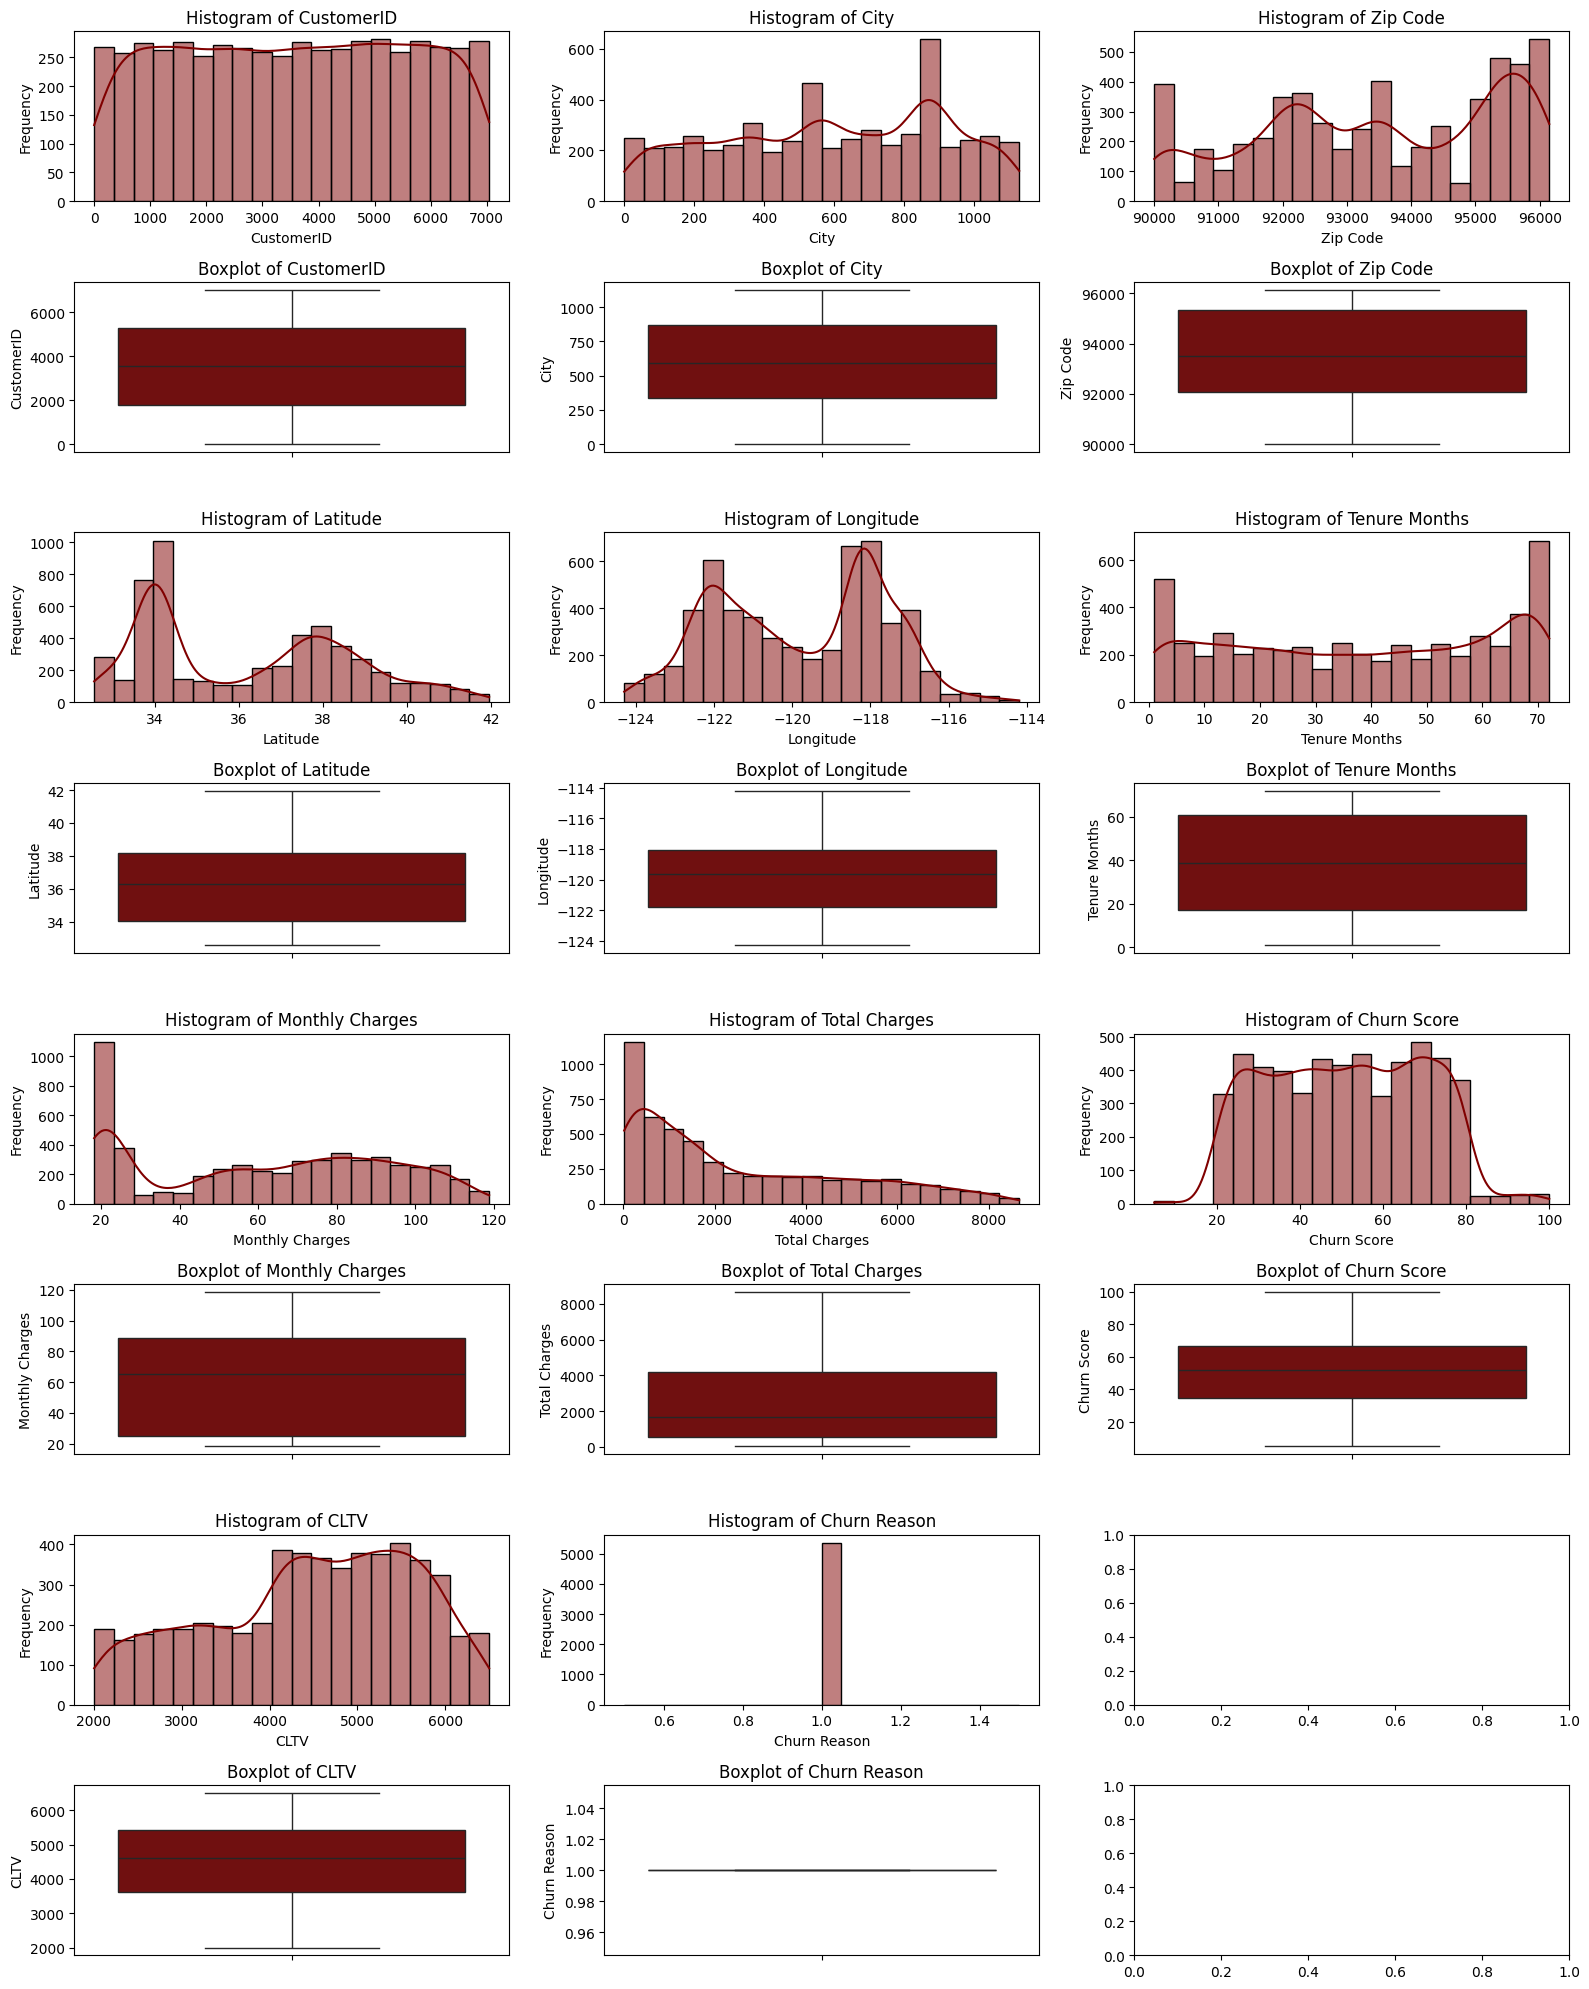

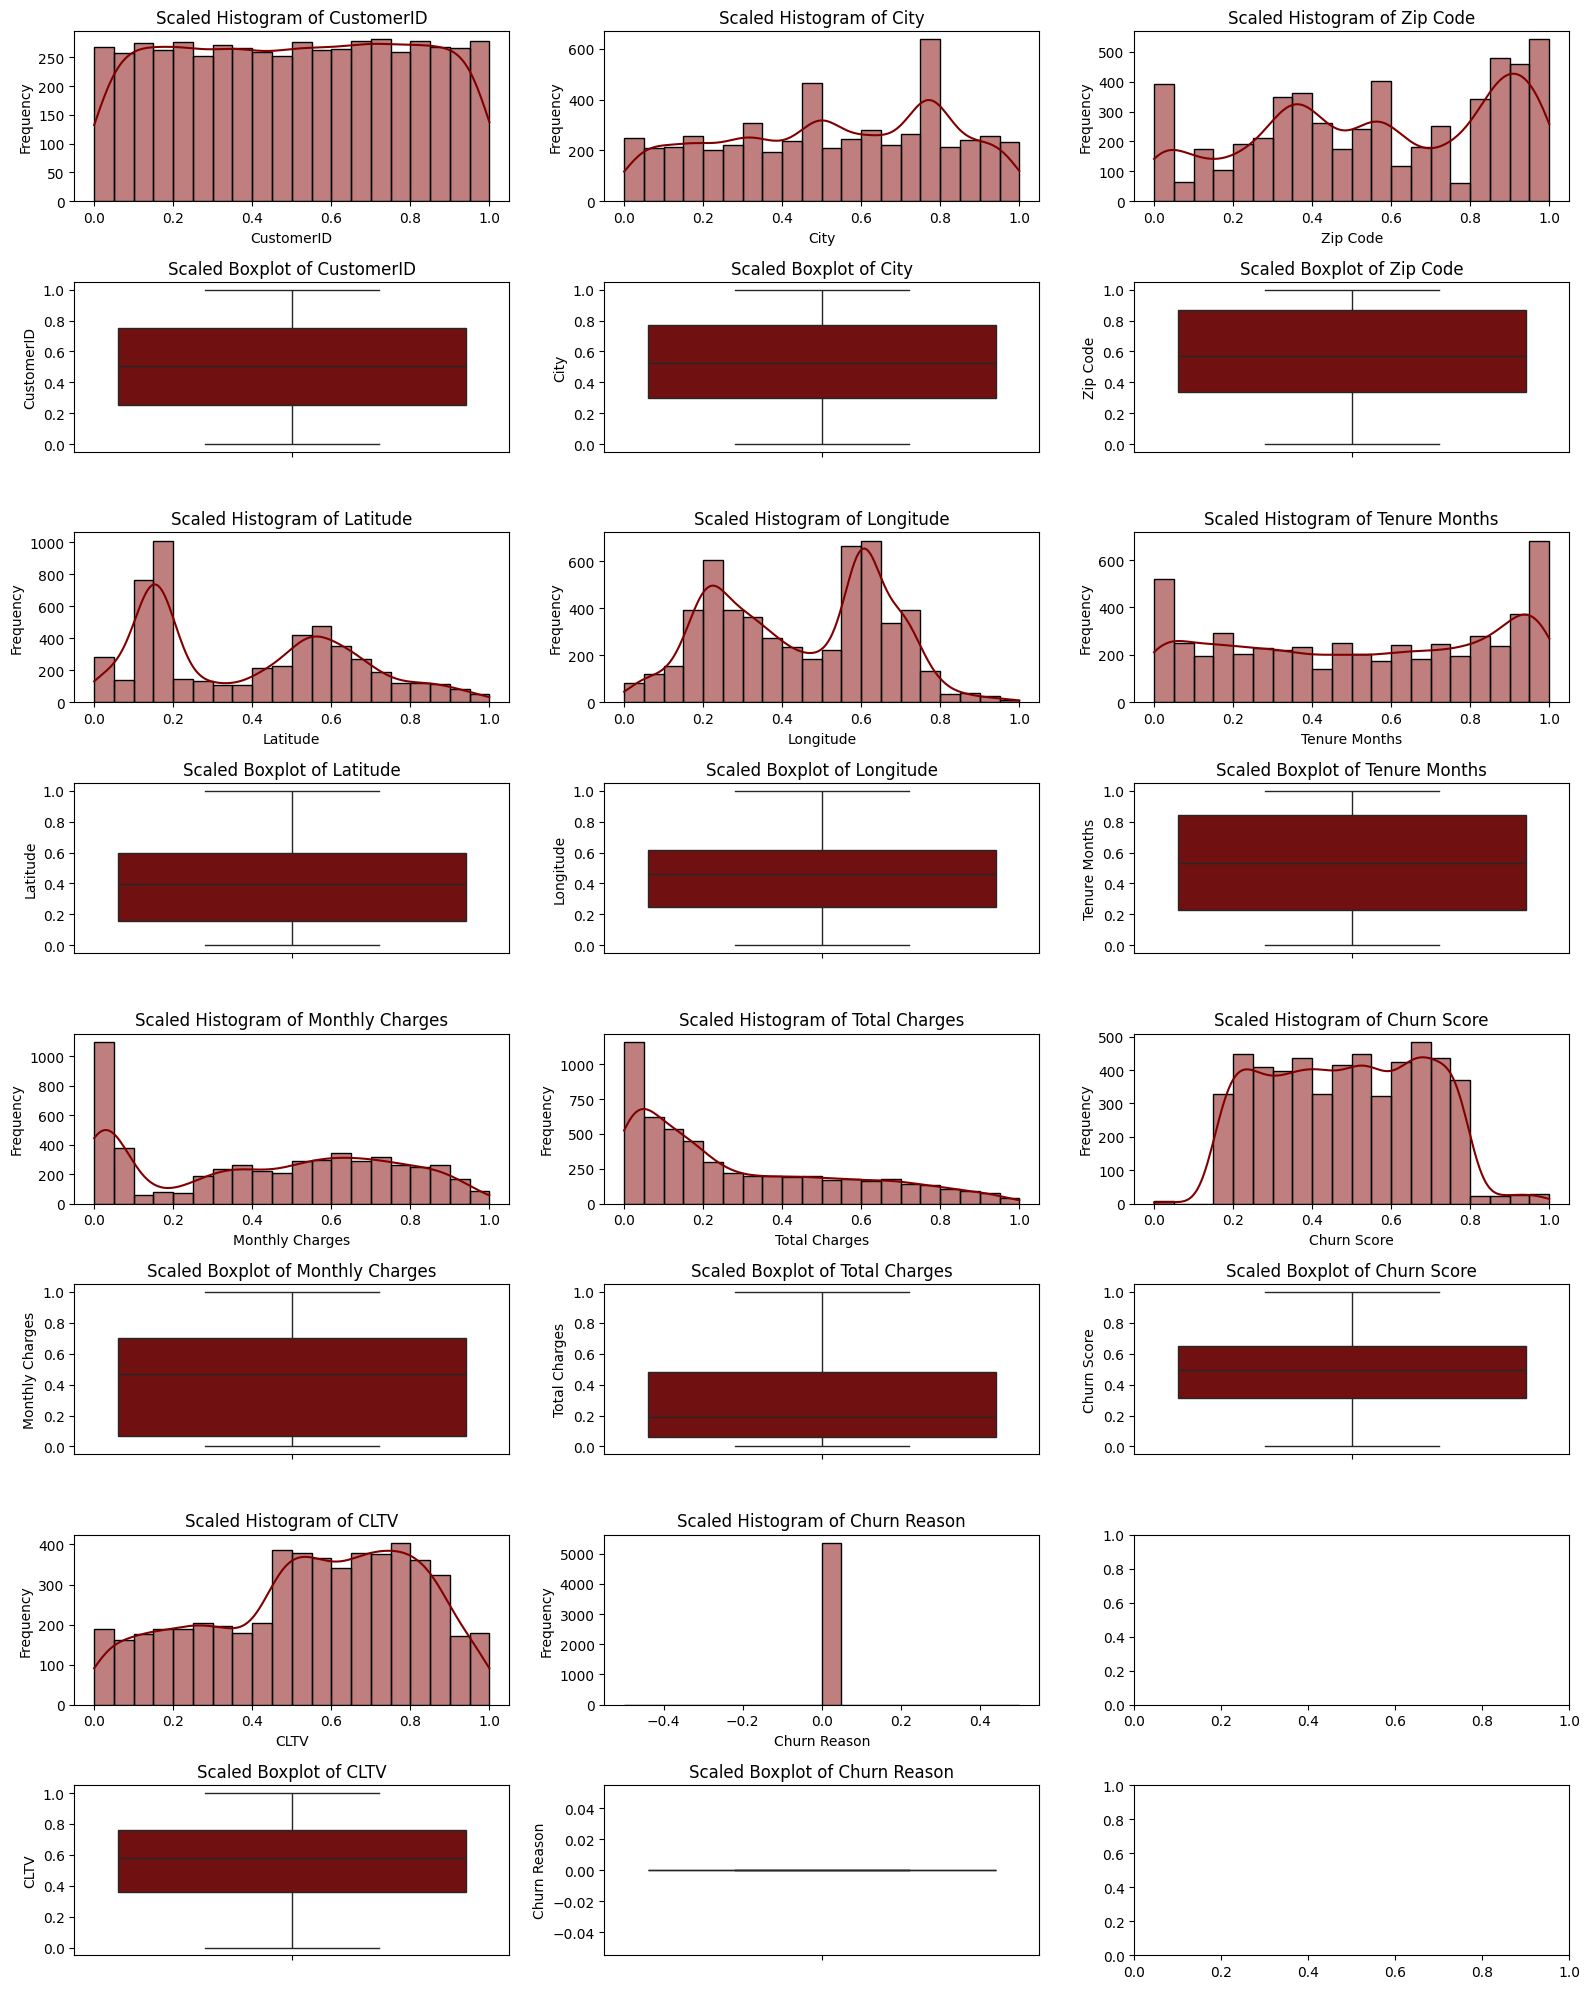

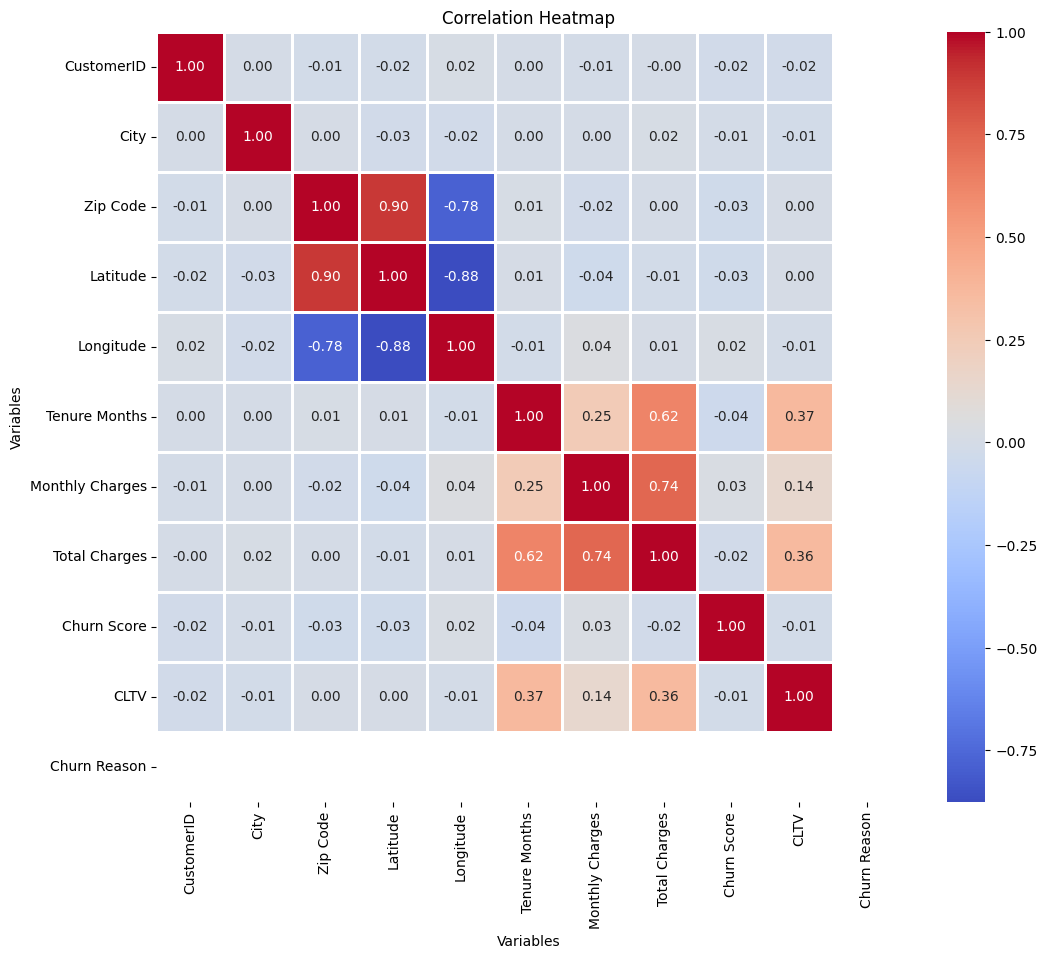

In [ ]:
FtrSlct(data);

In [38]:
correlated_columns = drop_highly_correlated_and_scale(data, threshold=0.8)


Columns to drop: ['Latitude', 'Longitude']


In [39]:
data= data.drop(columns=['Latitude','Longitude'])

In [40]:
data= data.drop(columns=['Churn Value'])

In [42]:
data= data.drop(columns=['Churn Reason'])

Performing Clustering without Boolean Variables

Dropping all the Boolean Variables to check the clustering results

In [43]:
data_2 = data.loc[:, data.dtypes.eq(float)]


In [ ]:
KYFS(data_2)

type  count  nunique     %unique  null  %null       min  \
CustomerID       float64   5355     5355  100.000000     0    0.0      0.00   
City             float64   5355     1121   20.933707     0    0.0      0.00   
Zip Code         float64   5355     1641   30.644258     0    0.0  90001.00   
Tenure Months    float64   5355       72    1.344538     0    0.0      1.00   
Monthly Charges  float64   5355     1469   27.432306     0    0.0     18.25   
Total Charges    float64   5355     5126   95.723623     0    0.0     18.80   
Churn Score      float64   5355       85    1.587302     0    0.0      5.00   
CLTV             float64   5355     3030   56.582633     0    0.0   2003.00   
Churn Reason     float64   5355        1    0.018674     0    0.0      1.00   

                      max  
CustomerID        7042.00  
City              1128.00  
Zip Code         96148.00  
Tenure Months       72.00  
Monthly Charges    118.75  
Total Charges     8672.45  
Churn Score        100.00  
CLTV              6500.00  
Churn Reason         1.00

In [ ]:
# Example usage:
data_2 = normalize_data(data_2)

New Ranges of the Features:
CustomerID: Min = 0.0, Max = 1.0
City: Min = 0.0, Max = 1.0
Zip Code: Min = 0.0, Max = 1.0
Tenure Months: Min = 0.0, Max = 1.0
Monthly Charges: Min = 0.0, Max = 0.9999999999999999
Total Charges: Min = 0.0, Max = 0.9999999999999999
Churn Score: Min = 0.0, Max = 1.0
CLTV: Min = 0.0, Max = 1.0
Churn Reason: Min = 0.0, Max = 0.0


In [ ]:
data_2 = np.log1p(data_2)  # log(1 + x) to handle zero values

In [ ]:
data_2.shape


(5355, 9)

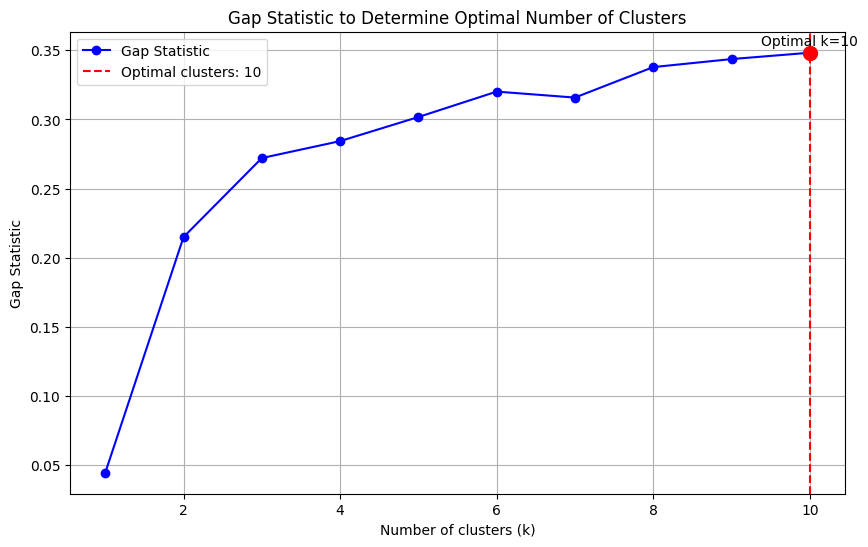

Optimal number of clusters detected: 10


In [ ]:
# Compute and visualize optimal number of clusters
optimal_clusters = gapstat(data_2)


Text(0, 0.5, 'WCSS')

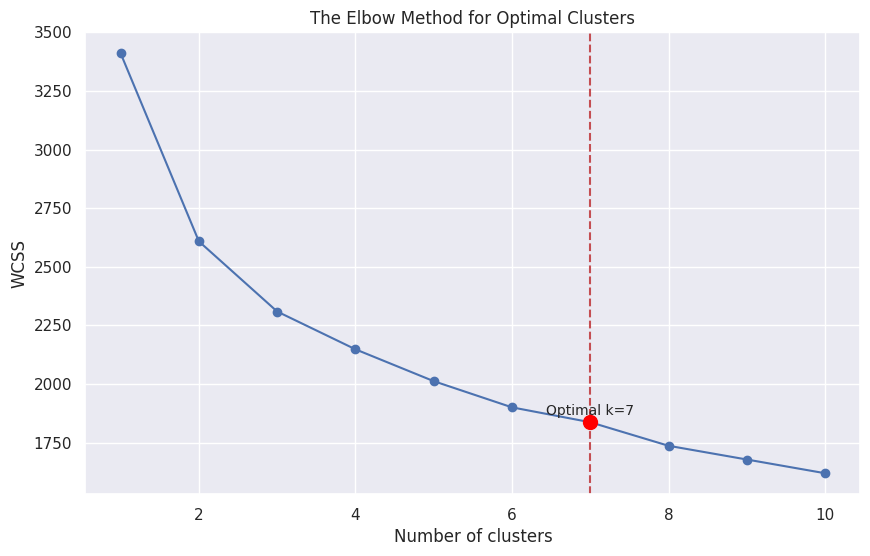

In [ ]:

# Calculate WCSS
wcss = calculate_wcss(data_2)

# Determine the optimal number of clusters
optimal_clusters = find_optimal_clusters(wcss)

# Plotting the elbow graph
plt.figure(figsize=(10, 6))
sns.set()
plt.plot(range(1, 11), wcss, marker='o', linestyle='-', color='b', label='WCSS')
plt.axvline(x=optimal_clusters, color='r', linestyle='--', label=f'Optimal clusters = {optimal_clusters}')
plt.scatter(optimal_clusters, wcss[optimal_clusters - 1], color='red', s=100, zorder=5)  # Mark the point

plt.annotate(
    f"Optimal k={optimal_clusters}",
    (optimal_clusters, wcss[optimal_clusters - 1]),
    textcoords="offset points",
    xytext=(0, 5),
    ha='center',
    fontsize=10
)

plt.title('The Elbow Method for Optimal Clusters')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')



Checking Silhoute scores on different different numbers of clusters

In [ ]:
kmeans_df, hierarchical_df = cluster_and_map_labels(data_2, n_clusters=2)


For Silhoute for the Continous features

In [ ]:
from sklearn.metrics import silhouette_score

# Calculate silhouette scores
sil_score_kmeans = silhouette_score(kmeans_df.drop(columns=['KMeans_Labels']), kmeans_df['KMeans_Labels'])
print(f"Silhouette Score for KMeans: {sil_score_kmeans}")


Silhouette Score for KMeans: 0.2112794945975729


In [ ]:
from sklearn.metrics import silhouette_score

sil_score_hierarchical = silhouette_score(hierarchical_df.drop(columns=['Hierarchical_Labels']), hierarchical_df['Hierarchical_Labels'])
print(f"Silhouette Score for Hierarchical Clustering: {sil_score_hierarchical}")


Silhouette Score for Hierarchical Clustering: 0.19634306016785225


For Davisboulden Index

In [ ]:
from sklearn.metrics import davies_bouldin_score
# Calculate Davies-Bouldin Index for KMeans
dbi_kmeans = davies_bouldin_score(
    kmeans_df.drop(columns=['KMeans_Labels']),
    kmeans_df['KMeans_Labels']
)
print(f"Davies-Bouldin Index for KMeans: {dbi_kmeans}")


Davies-Bouldin Index for KMeans: 1.700715936221711


In [ ]:
# Calculate Davies-Bouldin Index for Hierarchical Clustering
dbi_hierarchical = davies_bouldin_score(
    hierarchical_df.drop(columns=['Hierarchical_Labels']),
    hierarchical_df['Hierarchical_Labels']
)
print(f"Davies-Bouldin Index for Hierarchical Clustering: {dbi_hierarchical}")

Davies-Bouldin Index for Hierarchical Clustering: 1.6322369509998622


Now for Visualization

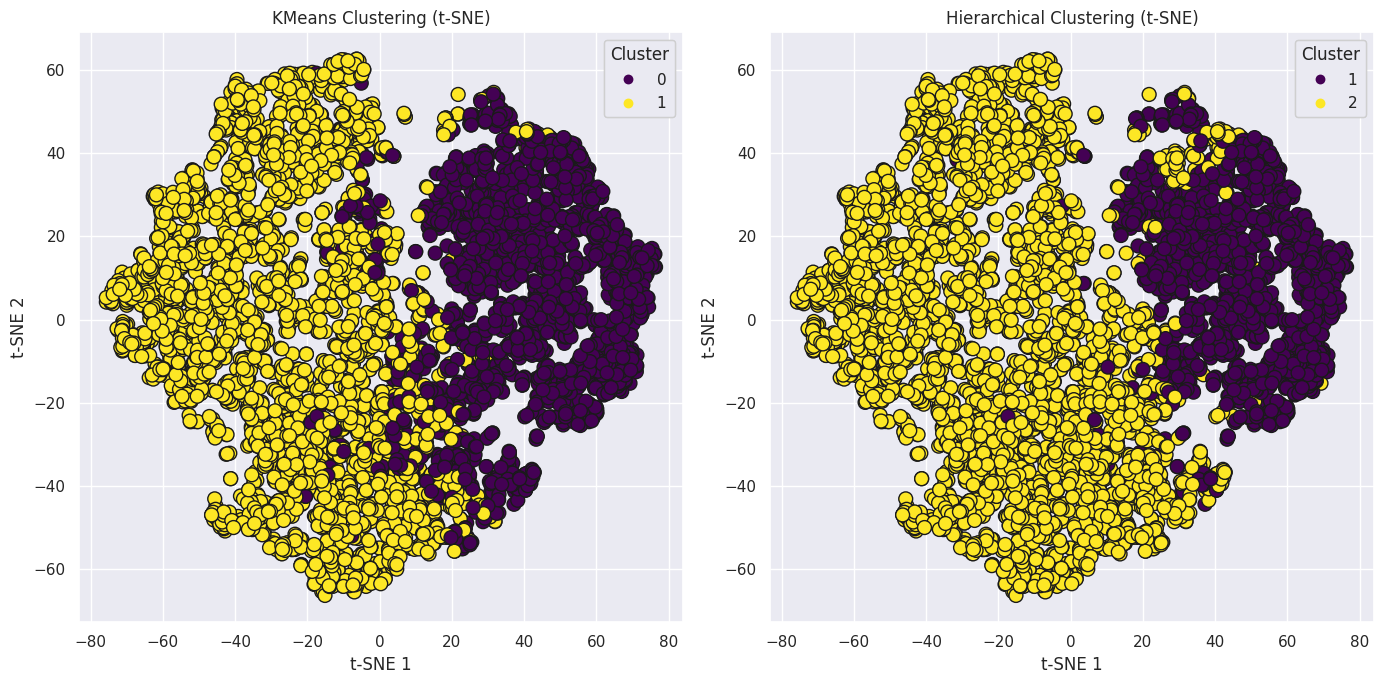

In [ ]:
# Call your visualization function
visualize_tsne_clusters(kmeans_df, hierarchical_df)


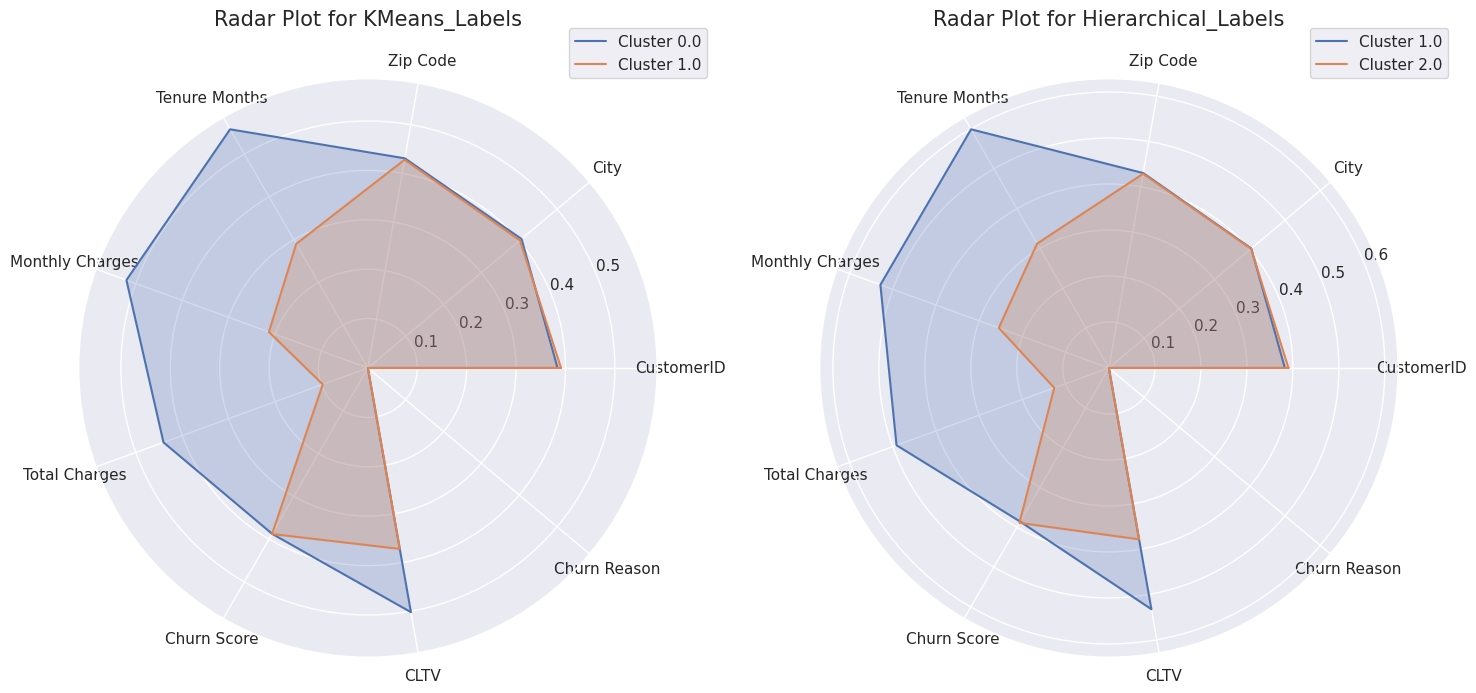

In [ ]:
compare_datasets(kmeans_df, 'KMeans_Labels', hierarchical_df, 'Hierarchical_Labels')


Now with the overall Dataset

In [ ]:

df = pd.DataFrame(data)

# Encode all object-type columns using LabelEncoder
le = LabelEncoder()
for col in df.select_dtypes(include=['object']).columns:
    df[col] = le.fit_transform(df[col].astype(str))

# Store the overall encoded dataset in the variable 'encoded_data'
encoded_data = df


In [ ]:
# Example usage:
encoded_df = normalize_data(encoded_data)

New Ranges of the Features:
CustomerID: Min = 0.0, Max = 1.0
City: Min = 0.0, Max = 1.0
Zip Code: Min = 0.0, Max = 1.0
Gender: Min = 0.0, Max = 1.0
Senior Citizen: Min = 0.0, Max = 1.0
Partner: Min = 0.0, Max = 1.0
Dependents: Min = 0.0, Max = 1.0
Tenure Months: Min = 0.0, Max = 1.0
Phone Service: Min = 0.0, Max = 1.0
Multiple Lines: Min = 0.0, Max = 1.0
Internet Service: Min = 0.0, Max = 1.0
Online Security: Min = 0.0, Max = 1.0
Online Backup: Min = 0.0, Max = 1.0
Device Protection: Min = 0.0, Max = 1.0
Tech Support: Min = 0.0, Max = 1.0
Streaming TV: Min = 0.0, Max = 1.0
Streaming Movies: Min = 0.0, Max = 1.0
Contract: Min = 0.0, Max = 1.0
Paperless Billing: Min = 0.0, Max = 1.0
Payment Method: Min = 0.0, Max = 1.0
Monthly Charges: Min = 0.0, Max = 0.9999999999999999
Total Charges: Min = 0.0, Max = 0.9999999999999999
Churn Value: Min = 0.0, Max = 1.0
Churn Score: Min = 0.0, Max = 1.0
CLTV: Min = 0.0, Max = 1.0
Churn Reason: Min = 0.0, Max = 0.0


In [ ]:
encoded_df = np.log1p(encoded_df)  # log(1 + x) to handle zero values

In [ ]:
kmeans_df, hierarchical_df = cluster_and_map_labels(encoded_df, n_clusters=2)


In [ ]:
from sklearn.metrics import silhouette_score

# Calculate silhouette scores
sil_score_kmeans = silhouette_score(kmeans_df.drop(columns=['KMeans_Labels']), kmeans_df['KMeans_Labels'])
print(f"Silhouette Score for KMeans: {sil_score_kmeans}")


Silhouette Score for KMeans: 0.10922010206278132


In [ ]:
from sklearn.metrics import silhouette_score

sil_score_hierarchical = silhouette_score(hierarchical_df.drop(columns=['Hierarchical_Labels']), hierarchical_df['Hierarchical_Labels'])
print(f"Silhouette Score for Hierarchical Clustering: {sil_score_hierarchical}")


Silhouette Score for Hierarchical Clustering: 0.09264680781751994


In [ ]:
from sklearn.metrics import davies_bouldin_score
# Calculate Davies-Bouldin Index for KMeans
dbi_kmeans = davies_bouldin_score(
    kmeans_df.drop(columns=['KMeans_Labels']),
    kmeans_df['KMeans_Labels']
)
print(f"Davies-Bouldin Index for KMeans: {dbi_kmeans}")


Davies-Bouldin Index for KMeans: 2.7534047429737685


In [ ]:
# Calculate Davies-Bouldin Index for Hierarchical Clustering
dbi_hierarchical = davies_bouldin_score(
    hierarchical_df.drop(columns=['Hierarchical_Labels']),
    hierarchical_df['Hierarchical_Labels']
)
print(f"Davies-Bouldin Index for Hierarchical Clustering: {dbi_hierarchical}")

Davies-Bouldin Index for Hierarchical Clustering: 2.9041821733798168


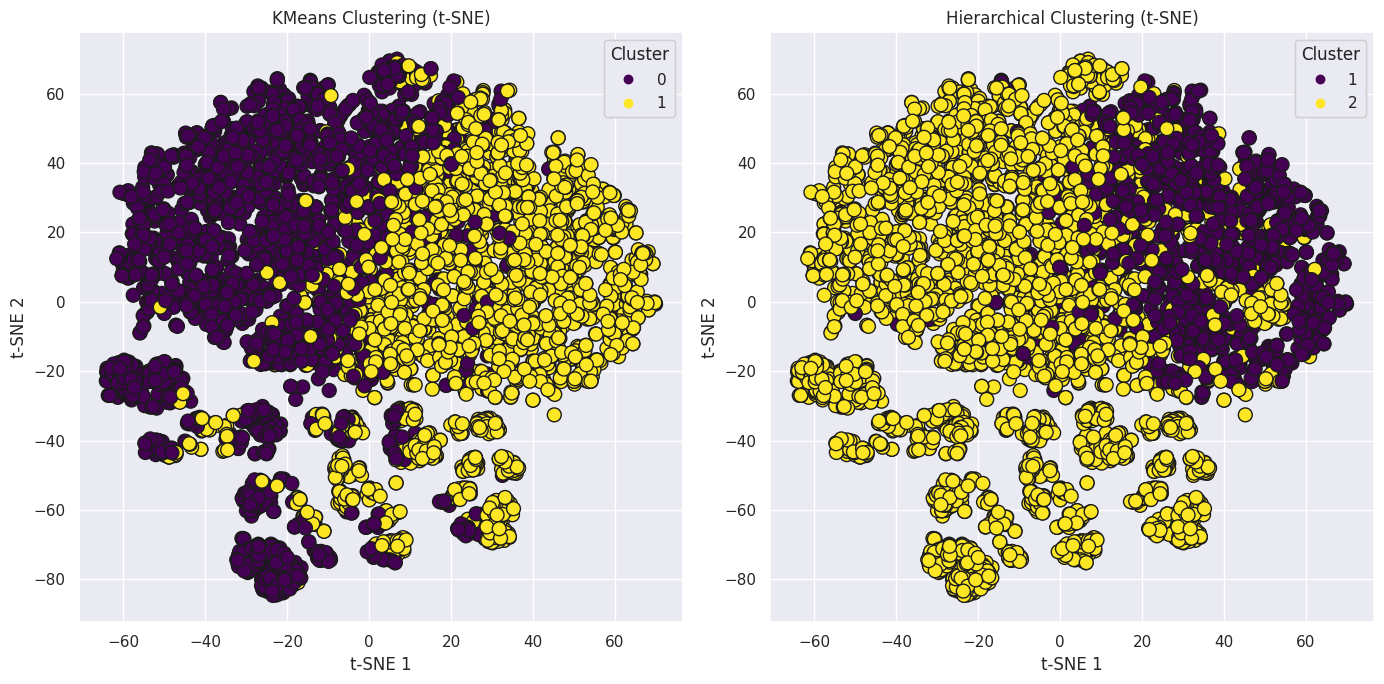

In [ ]:
# Call your visualization function
visualize_tsne_clusters(kmeans_df, hierarchical_df)


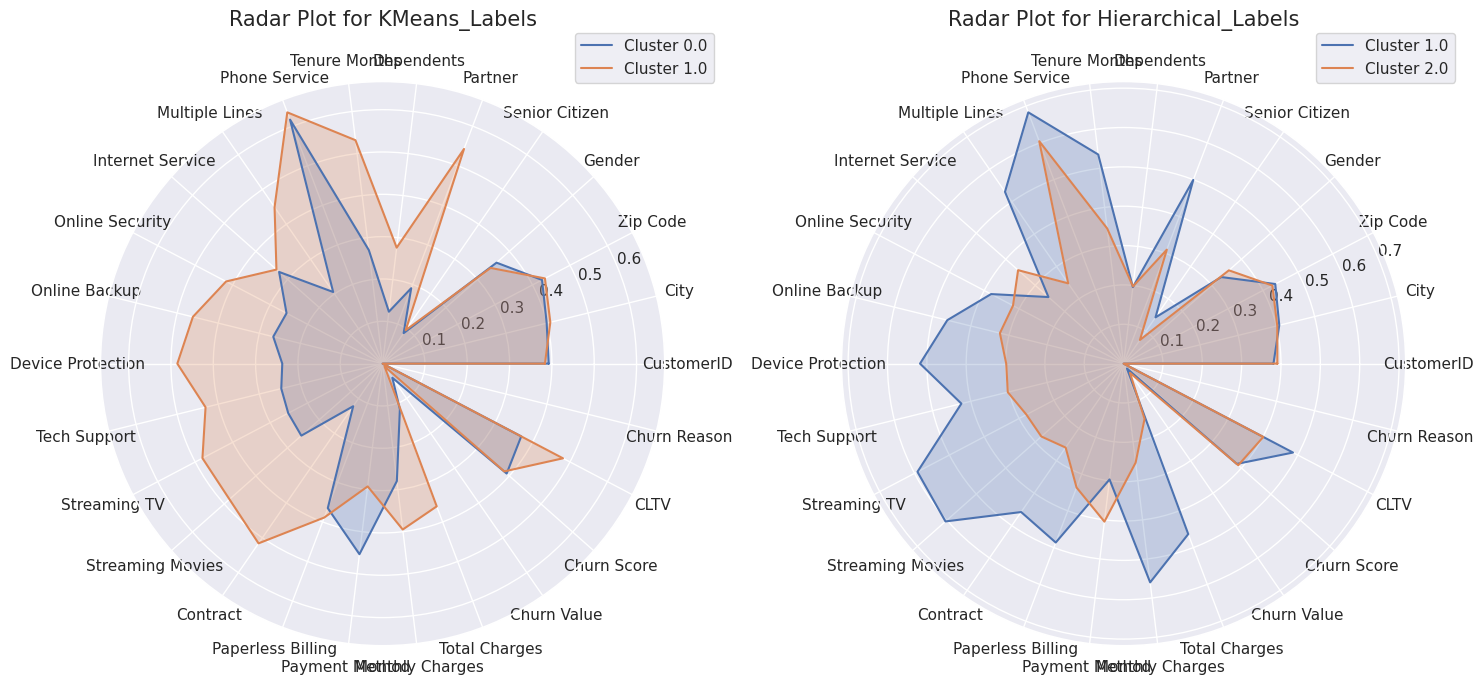

In [ ]:
compare_datasets(kmeans_df, 'KMeans_Labels', hierarchical_df, 'Hierarchical_Labels')


Boolean Variables Mitigation strategy

By working through K-Prototypes

In [44]:
# Identify Continuous Variables (type=float)
continuous_variables = data.select_dtypes(include=['float64']).columns.tolist()

# Identify Categorical Variables (type=bool)
categorical_variables = data.select_dtypes(include=['object']).columns.tolist()

print("Continuous Variables (float types):", continuous_variables)
print("Categorical Variables (boolean types):", categorical_variables)

Continuous Variables (float types): ['CustomerID', 'City', 'Zip Code', 'Tenure Months', 'Monthly Charges', 'Total Charges', 'Churn Score', 'CLTV']
Categorical Variables (boolean types): ['Gender', 'Senior Citizen', 'Partner', 'Dependents', 'Phone Service', 'Multiple Lines', 'Internet Service', 'Online Security', 'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV', 'Streaming Movies', 'Contract', 'Paperless Billing', 'Payment Method']


In [45]:
# Example Usage:
# Assuming `data` is your DataFrame with mixed types
clustered_df = cluster_and_map_labels(data, n_clusters=2)

# Save or process the resulting datasets
# clustered_df.to_csv('kprototypes_output.csv', index=False)


In [46]:
def encode_categorical_features(df):
    """
    Encodes all categorical columns numerically for silhouette computation.
    """
    df_encoded = df.copy()
    for col in df.select_dtypes(include=['object']).columns:
        le = LabelEncoder()
        df_encoded[col] = le.fit_transform(df[col])
    return df_encoded

In [48]:
clustered_df = encode_categorical_features(clustered_df)
# Calculate silhouette scores
from sklearn.metrics import silhouette_score

sil_score_kprototype = silhouette_score(clustered_df.drop(columns=['KPrototypes_Labels']), clustered_df['KPrototypes_Labels'])
print(f"Silhouette Score for K-Protype: {sil_score_kprototype}")


Silhouette Score for K-Protype: 0.3019811403657913


In [ ]:
#Calculate DBI

# Calculate Davies-Bouldin Index for KMeans
dbi_kprototype= davies_bouldin_score(
    clustered_df.drop(columns=['KPrototypes_Labels']),
    clustered_df['KPrototypes_Labels']
)
print(f"Davies-Bouldin Index for KPrototype: {dbi_kprototype}")

Davies-Bouldin Index for KPrototype: 1.374008821244519


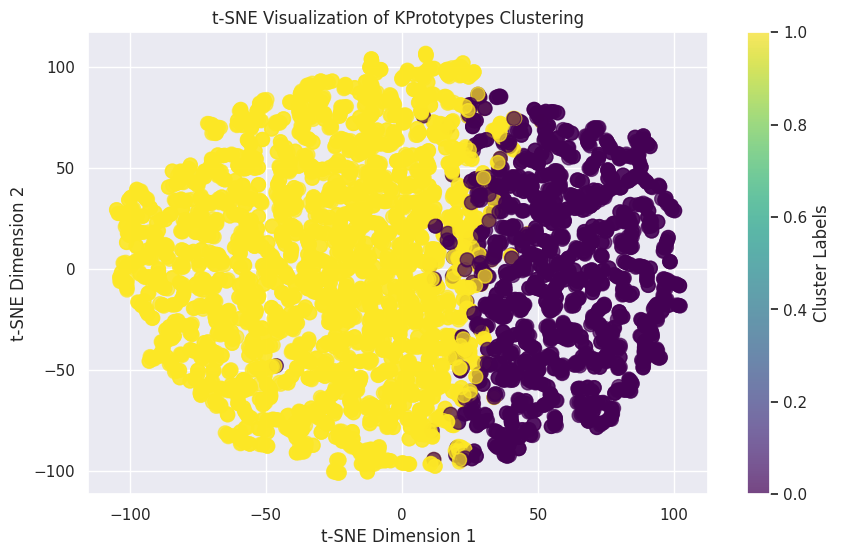

In [ ]:
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# t-SNE Visualization for the clustered results
def visualize_tsne(clustered_df):
    """
    Visualizes the clustering results using t-SNE.

    Args:
        clustered_df (pd.DataFrame): DataFrame containing mixed numerical + categorical data and cluster labels.
    """
    # Encode data to handle categorical variables
    encoded_df = encode_categorical_features(clustered_df.drop(columns=['KPrototypes_Labels']))

    # Run t-SNE
    tsne = TSNE(n_components=2, random_state=42, perplexity=5)  # n_components=2 reduces data to 2D
    tsne_results = tsne.fit_transform(encoded_df)

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=clustered_df['KPrototypes_Labels'], cmap='viridis', s=100, alpha=0.7)
    plt.colorbar(label="Cluster Labels")
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.title("t-SNE Visualization of KPrototypes Clustering")
    plt.show()


# Example Usage
visualize_tsne(clustered_df)

In [49]:
clustered_df = normalize_data(clustered_df)

New Ranges of the Features:
CustomerID: Min = 0.0, Max = 1.0
City: Min = 0.0, Max = 1.0
Zip Code: Min = 0.0, Max = 1.0
Gender: Min = 0.0, Max = 1.0
Senior Citizen: Min = 0.0, Max = 1.0
Partner: Min = 0.0, Max = 1.0
Dependents: Min = 0.0, Max = 1.0
Tenure Months: Min = 0.0, Max = 1.0
Phone Service: Min = 0.0, Max = 1.0
Multiple Lines: Min = 0.0, Max = 1.0
Internet Service: Min = 0.0, Max = 1.0
Online Security: Min = 0.0, Max = 1.0
Online Backup: Min = 0.0, Max = 1.0
Device Protection: Min = 0.0, Max = 1.0
Tech Support: Min = 0.0, Max = 1.0
Streaming TV: Min = 0.0, Max = 1.0
Streaming Movies: Min = 0.0, Max = 1.0
Contract: Min = 0.0, Max = 1.0
Paperless Billing: Min = 0.0, Max = 1.0
Payment Method: Min = 0.0, Max = 1.0
Monthly Charges: Min = 0.0, Max = 0.9999999999999999
Total Charges: Min = 0.0, Max = 0.9999999999999999
Churn Score: Min = 0.0, Max = 1.0
CLTV: Min = 0.0, Max = 1.0
KPrototypes_Labels: Min = 0.0, Max = 1.0


In [54]:
clustered_df = clustered_df.astype(float)


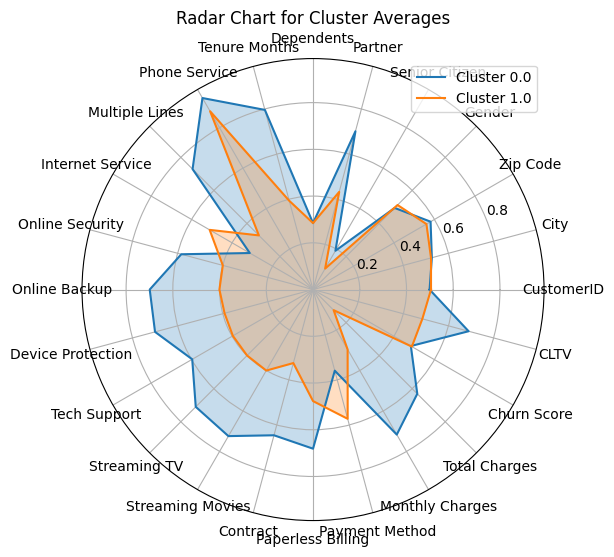

In [57]:
# Create a figure and axis for the radar plot
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw={'polar': True})

# Call the plot_radar function
plot_radar(label_column_name='KPrototypes_Labels', clustered_df=clustered_df, ax=ax)

# Set the title and display the radar plot
ax.set_title('Radar Chart for Cluster Averages')
plt.show()

Now Using PCA Method to improve the Clusteirng

In [58]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score


# 1. Encode data
encoder = LabelEncoder()
encoded_data = data.apply(encoder.fit_transform)  # Encoding all columns
print("Encoded Data:\n", encoded_data.head())

# 2. Standardize encoded data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(encoded_data)

# 3. PCA Transformation
n_components = 2 # You can adjust the number of PCA components
pca = PCA(n_components=n_components)
pca_data = pca.fit_transform(scaled_data)

# Function to compute clustering and metrics
def compute_clustering_metrics(cluster_method, data_to_cluster):
    """
    Perform clustering (KMeans or Hierarchical), map labels back to original data,
    and compute silhouette and DBI scores.
    """
    # Apply clustering
    if cluster_method == 'KMeans':
        clustering_model = KMeans(n_clusters=2, random_state=42)  # Set clusters as 3
    elif cluster_method == 'Hierarchical':
        clustering_model = AgglomerativeClustering(n_clusters=2, linkage='ward')
    else:
        raise ValueError("Unknown clustering method")

    # Fit clustering model and get labels
    cluster_labels = clustering_model.fit_predict(data_to_cluster)

    # Calculate metrics
    silhouette_avg = silhouette_score(data_to_cluster, cluster_labels)
    davies_bouldin = davies_bouldin_score(data_to_cluster, cluster_labels)

    print(f"\nResults for {cluster_method} clustering:")
    print(f"Silhouette Score: {silhouette_avg}")
    print(f"Davies-Bouldin Index (DBI): {davies_bouldin}")

    return cluster_labels, silhouette_avg, davies_bouldin


# Run KMeans clustering
kmeans_labels, kmeans_silhouette, kmeans_dbi = compute_clustering_metrics(
    'KMeans', pca_data
)

# Run Hierarchical clustering
hierarchical_labels, hierarchical_silhouette, hierarchical_dbi = compute_clustering_metrics(
    'Hierarchical', pca_data
)

# Map the clustering labels back to two separate datasets
data_kmeans = encoded_data.copy()
data_kmeans['KMeans_Labels'] = kmeans_labels

data_hierarchical = encoded_data.copy()
data_hierarchical['Hierarchical_Labels'] = hierarchical_labels

# Display mapped results for KMeans
print("\nData with KMeans Labels:\n", data_kmeans.head())

# Display mapped results for Hierarchical clustering
print("\nData with Hierarchical Labels:\n", data_hierarchical.head())


Encoded Data:
      CustomerID  City  Zip Code  Gender  Senior Citizen  Partner  Dependents  \
199        2254   578       804       1               0        1           0   
200         931   578       805       1               0        0           0   
201        1157   608       806       1               0        0           0   
205        1203   874       821       0               0        1           0   
302          67   546      1157       0               0        0           0   

     Tenure Months  Phone Service  Multiple Lines  ...  Tech Support  \
199             34              1               2  ...             0   
200              0              1               0  ...             0   
201             53              1               2  ...             0   
205              7              1               0  ...             0   
302              3              1               2  ...             0   

     Streaming TV  Streaming Movies  Contract  Paperless Billing  \
199

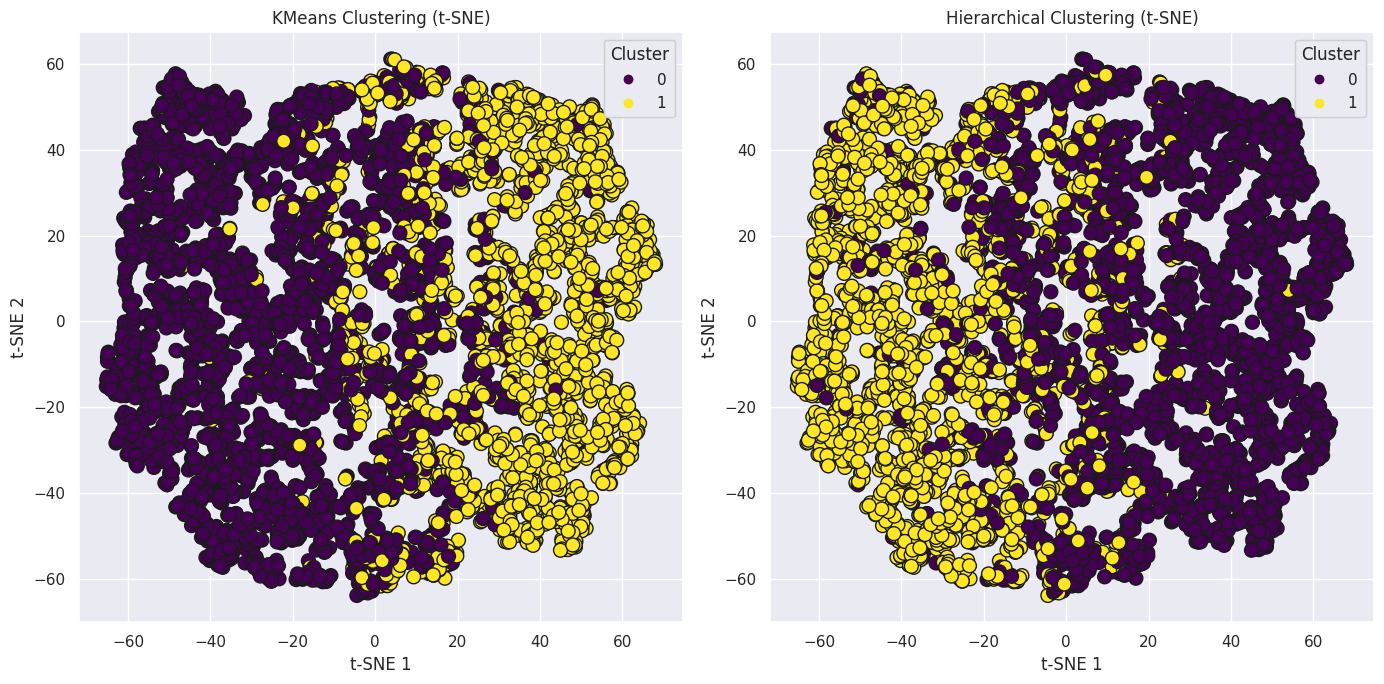

In [ ]:
# Call your visualization function
visualize_tsne_clusters(data_kmeans, data_hierarchical)


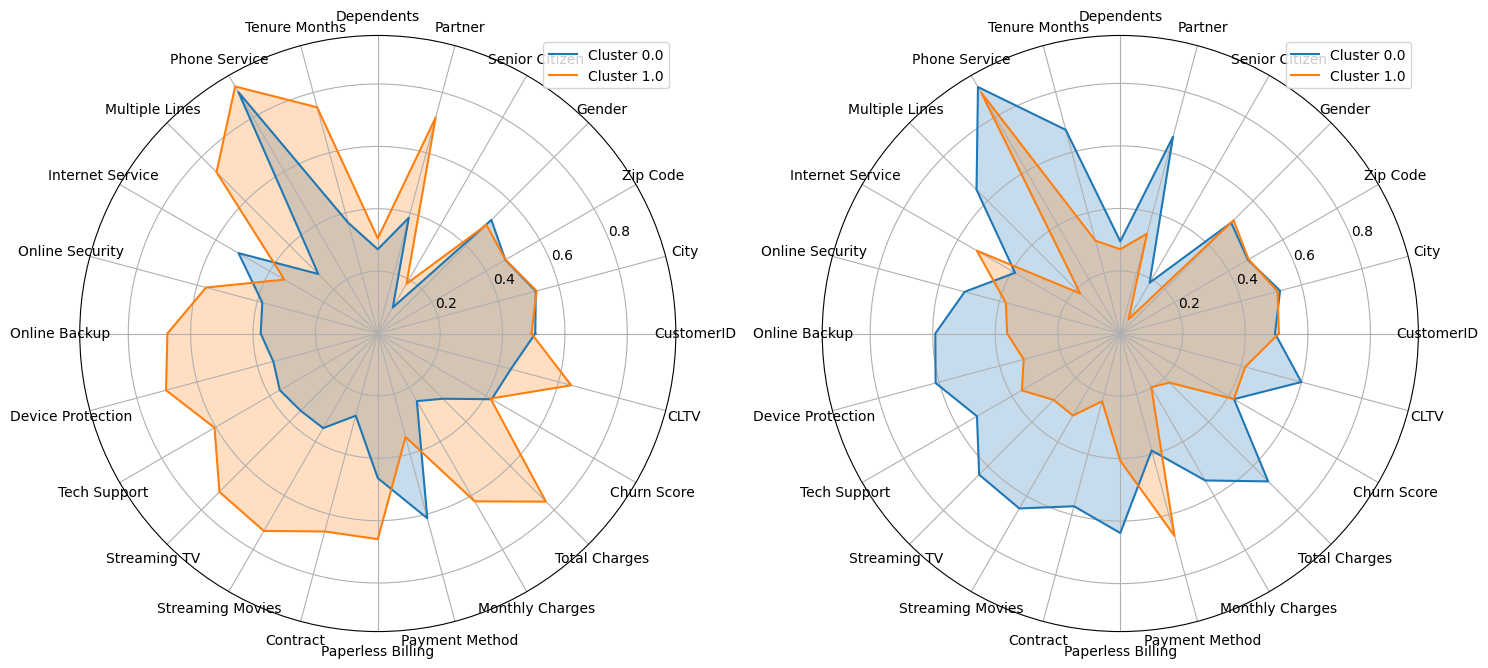

In [61]:
compare_datasets(data_kmeans, 'KMeans_Labels', data_hierarchical, 'Hierarchical_Labels')


In [ ]:
import pandas as pd

# Given data
# Effects Without Boolean
silhouette_kmeans_no_bool = 0.2112794945975729
silhouette_hierarchical_no_bool = 0.19634306016785225
davies_kmeans_no_bool = 1.700715936221711
davies_hierarchical_no_bool = 1.6322369509998622

# Effects With Boolean
silhouette_kmeans_with_bool = 0.10922010206278132
silhouette_hierarchical_with_bool = 0.09264680781751994
davies_kmeans_with_bool = 2.7534047429737685
davies_hierarchical_with_bool = 2.9041821733798168

# Calculate percent change
silhouette_kmeans_pct_change = ((silhouette_kmeans_with_bool - silhouette_kmeans_no_bool) / silhouette_kmeans_no_bool) * 100
silhouette_hierarchical_pct_change = ((silhouette_hierarchical_with_bool - silhouette_hierarchical_no_bool) / silhouette_hierarchical_no_bool) * 100
davies_kmeans_pct_change = ((davies_kmeans_with_bool - davies_kmeans_no_bool) / davies_kmeans_no_bool) * 100
davies_hierarchical_pct_change = ((davies_hierarchical_with_bool - davies_hierarchical_no_bool) / davies_hierarchical_no_bool) * 100

# Prepare data for DataFrame
data = {
    "Metric": [
        "Silhouette Score for KMeans",
        "Silhouette Score for Hierarchical Clustering",
        "Davies-Bouldin Index for KMeans",
        "Davies-Bouldin Index for Hierarchical Clustering"
    ],
    "Effect Without Boolean": [
        silhouette_kmeans_no_bool,
        silhouette_hierarchical_no_bool,
        davies_kmeans_no_bool,
        davies_hierarchical_no_bool
    ],
    "Effect With Boolean": [
        silhouette_kmeans_with_bool,
        silhouette_hierarchical_with_bool,
        davies_kmeans_with_bool,
        davies_hierarchical_with_bool
    ],
    "Percent Change (%)": [
        silhouette_kmeans_pct_change,
        silhouette_hierarchical_pct_change,
        davies_kmeans_pct_change,
        davies_hierarchical_pct_change
    ],
    "Remarks": [
        "Silhouette Score for KMeans dropped by 48.3%, showing poor clustering.",
        "Silhouette Score for Hierarchical Clustering dropped by 53.2%, poor clustering.",
        "Davies-Bouldin Index for KMeans worsened by 62.1% with Boolean variables.",
        "Davies-Bouldin Index for Hierarchical worsened by 78.5% with Boolean variables."
    ]
}

# Convert to DataFrame for better tabular representation
df = pd.DataFrame(data)

# Print the heading for interpretation
print("\n**Final Interpretation**\n")  # Simple text heading for Colab compatibility

# Display the DataFrame nicely
import IPython
from IPython.display import display
display(df)  # Render the table cleanly in Google Colab



**Final Interpretation**



Metric  Effect Without Boolean  \
0                       Silhouette Score for KMeans                0.211279   
1      Silhouette Score for Hierarchical Clustering                0.196343   
2                   Davies-Bouldin Index for KMeans                1.700716   
3  Davies-Bouldin Index for Hierarchical Clustering                1.632237   

   Effect With Boolean  Percent Change (%)  \
0             0.109220          -48.305394   
1             0.092647          -52.813811   
2             2.753405           61.896804   
3             2.904182           77.926506   

                                             Remarks  
0  Silhouette Score for KMeans dropped by 48.3%, ...  
1  Silhouette Score for Hierarchical Clustering d...  
2  Davies-Bouldin Index for KMeans worsened by 62...  
3  Davies-Bouldin Index for Hierarchical worsened...

In [ ]:
import pandas as pd

# Given data - Standard Boolean effects
silhouette_kmeans_bool = 0.10922010206278132
silhouette_hierarchical_bool = 0.09264680781751994
davies_kmeans_bool = 2.7534047429737685
davies_hierarchical_bool = 2.9041821733798168

# Mitigation Strategy - KPrototype effects
silhouette_kprototype = 0.3019811403657913
davies_kprototype = 1.374008821244519

# Mitigation Strategy - PCA effects
silhouette_kmeans_pca = 0.41049440247806257
silhouette_hierarchical_pca = 0.35399652346184013
davies_kmeans_pca = 0.9511062088322325
davies_hierarchical_pca = 1.0406075243015342

# Calculate percent change for KPrototype vs Boolean
silhouette_kprototype_pct_change = ((silhouette_kprototype - silhouette_kmeans_bool) / silhouette_kmeans_bool) * 100
davies_kprototype_pct_change = ((davies_kprototype - davies_kmeans_bool) / davies_kmeans_bool) * 100

# Calculate percent change for PCA vs standard Boolean
silhouette_kmeans_pca_pct_change = ((silhouette_kmeans_pca - silhouette_kmeans_bool) / silhouette_kmeans_bool) * 100
silhouette_hierarchical_pca_pct_change = ((silhouette_hierarchical_pca - silhouette_hierarchical_bool) / silhouette_hierarchical_bool) * 100
davies_kmeans_pca_pct_change = ((davies_kmeans_pca - davies_kmeans_bool) / davies_kmeans_bool) * 100
davies_hierarchical_pca_pct_change = ((davies_hierarchical_pca - davies_hierarchical_bool) / davies_hierarchical_bool) * 100

# Prepare data for DataFrame
data = {
    "Metric": [
        "Silhouette Score - KPrototype vs KMeans",
        "Davies-Bouldin Index - KPrototype vs KMeans",
        "Silhouette Score - PCA vs KMeans",
        "Silhouette Score - PCA vs Hierarchical",
        "Davies-Bouldin Index - PCA vs KMeans",
        "Davies-Bouldin Index - PCA vs Hierarchical"
    ],
    "Effect With Mitigation Strategy": [
        silhouette_kprototype,
        davies_kprototype,
        silhouette_kmeans_pca,
        silhouette_hierarchical_pca,
        davies_kmeans_pca,
        davies_hierarchical_pca
    ],
    "Effect With Boolean Baseline": [
        silhouette_kmeans_bool,
        davies_kmeans_bool,
        silhouette_kmeans_bool,
        silhouette_hierarchical_bool,
        davies_kmeans_bool,
        davies_hierarchical_bool
    ],
    "Percent Change (%)": [
        silhouette_kprototype_pct_change,
        davies_kprototype_pct_change,
        silhouette_kmeans_pca_pct_change,
        silhouette_hierarchical_pca_pct_change,
        davies_kmeans_pca_pct_change,
        davies_hierarchical_pca_pct_change
    ],
    "Remarks": [
        "KPrototype Silhouette Score shows 176% improvement over KMeans.",
        "Davies-Bouldin Index with KPrototype suggests better clustering by decreasing DBI.",
        "PCA improved KMeans Silhouette Score by ~275%.",
        "PCA improved the Hierarchical Silhouette Score performance significantly.",
        "Davies-Bouldin Index with PCA shows clustering improvements over KMeans baseline.",
        "Davies-Bouldin Index with PCA has better clustering performance compared to the Boolean baseline."
    ]
}

# Convert the data dictionary to a DataFrame
df = pd.DataFrame(data)

# Print the heading for interpretation
print("\n**\033[1;31mFinal Interpretation\033[0m**\n")  # Rendered red bold text for emphasis in Colab

# Display the DataFrame nicely
from IPython.display import display
display(df)  # Render the data table in Google Colab for easy tabular visualization



**Final Interpretation**



Metric  \
0      Silhouette Score - KPrototype vs KMeans   
1  Davies-Bouldin Index - KPrototype vs KMeans   
2             Silhouette Score - PCA vs KMeans   
3       Silhouette Score - PCA vs Hierarchical   
4         Davies-Bouldin Index - PCA vs KMeans   
5   Davies-Bouldin Index - PCA vs Hierarchical   

   Effect With Mitigation Strategy  Effect With Boolean Baseline  \
0                         0.301981                      0.109220   
1                         1.374009                      2.753405   
2                         0.410494                      0.109220   
3                         0.353997                      0.092647   
4                         0.951106                      2.753405   
5                         1.040608                      2.904182   

   Percent Change (%)                                            Remarks  
0          176.488608  KPrototype Silhouette Score shows 176% improve...  
1          -50.097826  Davies-Bouldin Index with KPrototype suggests ...  
2          275.841438     PCA improved KMeans Silhouette Score by ~275%.  
3          282.092521  PCA improved the Hierarchical Silhouette Score...  
4          -65.457087  Davies-Bouldin Index with PCA shows clustering...  
5          -64.168655  Davies-Bouldin Index with PCA has better clust...

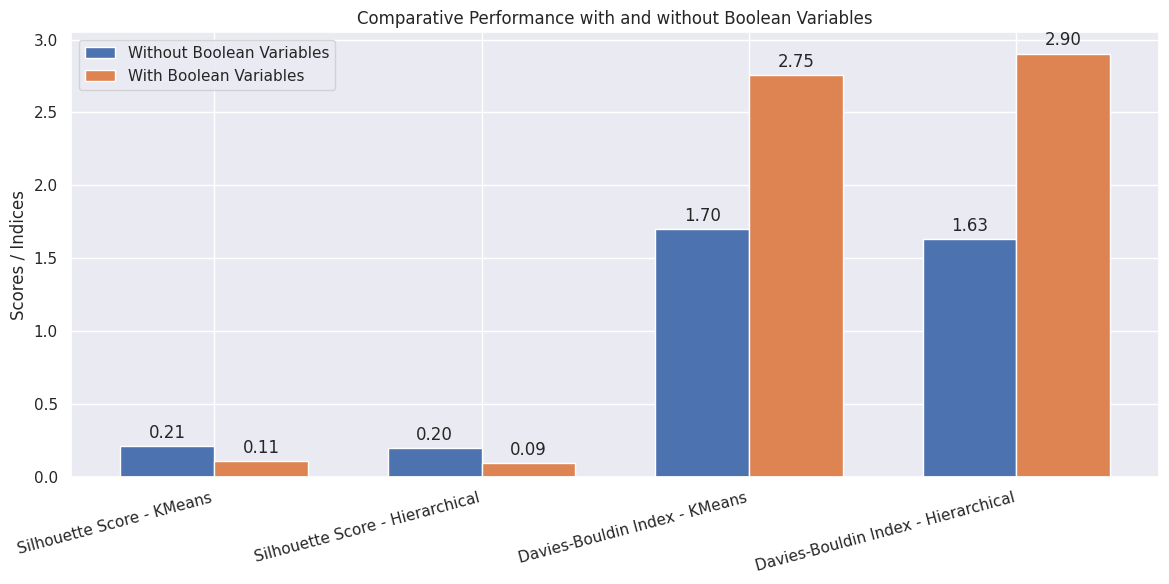

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data: Effects without and with Boolean variables
metrics = [
    "Silhouette Score - KMeans",
    "Silhouette Score - Hierarchical",
    "Davies-Bouldin Index - KMeans",
    "Davies-Bouldin Index - Hierarchical"
]

# Values without Boolean variables
effects_no_bool = [
    0.2112794945975729,  # Silhouette Score for KMeans without Boolean
    0.19634306016785225,  # Silhouette Score for Hierarchical without Boolean
    1.700715936221711,    # Davies-Bouldin Index for KMeans without Boolean
    1.6322369509998622    # Davies-Bouldin Index for Hierarchical without Boolean
]

# Values with Boolean variables
effects_with_bool = [
    0.10922010206278132,  # Silhouette Score for KMeans with Boolean
    0.09264680781751994,  # Silhouette Score for Hierarchical with Boolean
    2.7534047429737685,   # Davies-Bouldin Index for KMeans with Boolean
    2.9041821733798168    # Davies-Bouldin Index for Hierarchical with Boolean
]

# Set up bar plot
x = np.arange(len(metrics))  # Index for x-axis
width = 0.35  # Width of bars

# Create the plot
fig, ax = plt.subplots(figsize=(12, 6))

# Bar positions for comparisons
bar1 = ax.bar(x - width / 2, effects_no_bool, width, label='Without Boolean Variables')
bar2 = ax.bar(x + width / 2, effects_with_bool, width, label='With Boolean Variables')

# Adding text and titles
ax.set_ylabel('Scores / Indices')
ax.set_xticks(x)
ax.set_xticklabels(metrics, rotation=15, ha="right")
ax.legend()

# Add labels above the bars for clarity
for bar in bar1:
    ax.annotate(f'{bar.get_height():.2f}',
                xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()),
                xytext=(0, 3),  # Offset text position
                textcoords="offset points",
                ha='center', va='bottom')

for bar in bar2:
    ax.annotate(f'{bar.get_height():.2f}',
                xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom')

# Final graph titles
ax.set_title('Comparative Performance with and without Boolean Variables')
plt.tight_layout()

# Show the bar graph
plt.show()


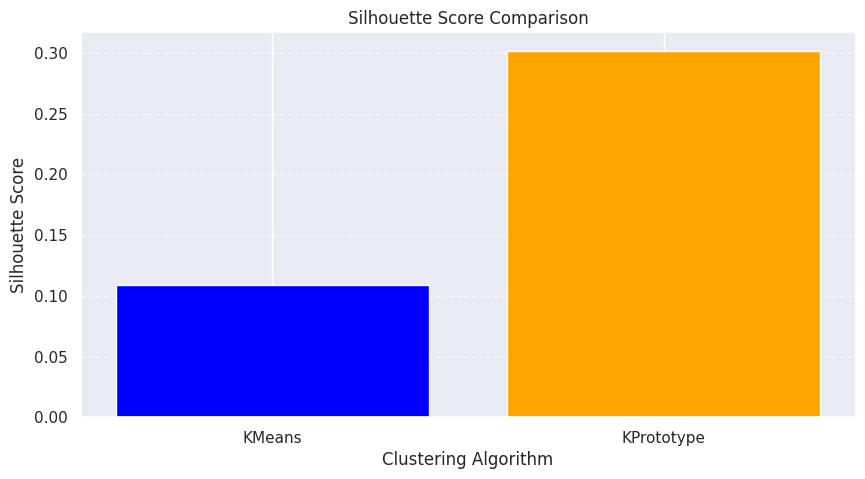

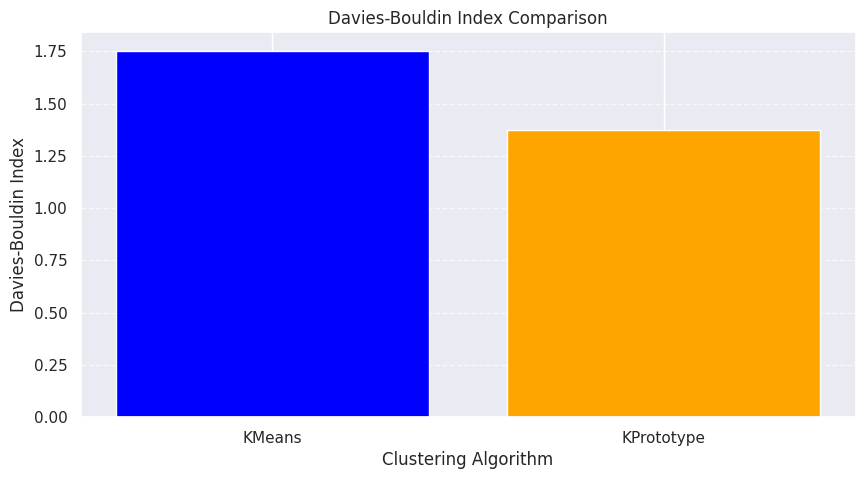

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Provided data
# Metrics for KMeans and KPrototype
silhouette_scores = {
    'KMeans': 0.10922010206278132,
    'KPrototype': 0.3019811403657913
}

davies_bouldin_scores = {
    'KMeans': 1.7534047429737685,
    'KPrototype': 1.374008821244519
}

# Bar Graph 1: Silhouette Score Comparison
plt.figure(figsize=(10, 5))
plt.bar(silhouette_scores.keys(), silhouette_scores.values(), color=['blue', 'orange'])
plt.title('Silhouette Score Comparison')
plt.ylabel('Silhouette Score')
plt.xlabel('Clustering Algorithm')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Bar Graph 2: Davies-Bouldin Index Comparison
plt.figure(figsize=(10, 5))
plt.bar(davies_bouldin_scores.keys(), davies_bouldin_scores.values(), color=['blue', 'orange'])
plt.title('Davies-Bouldin Index Comparison')
plt.ylabel('Davies-Bouldin Index')
plt.xlabel('Clustering Algorithm')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


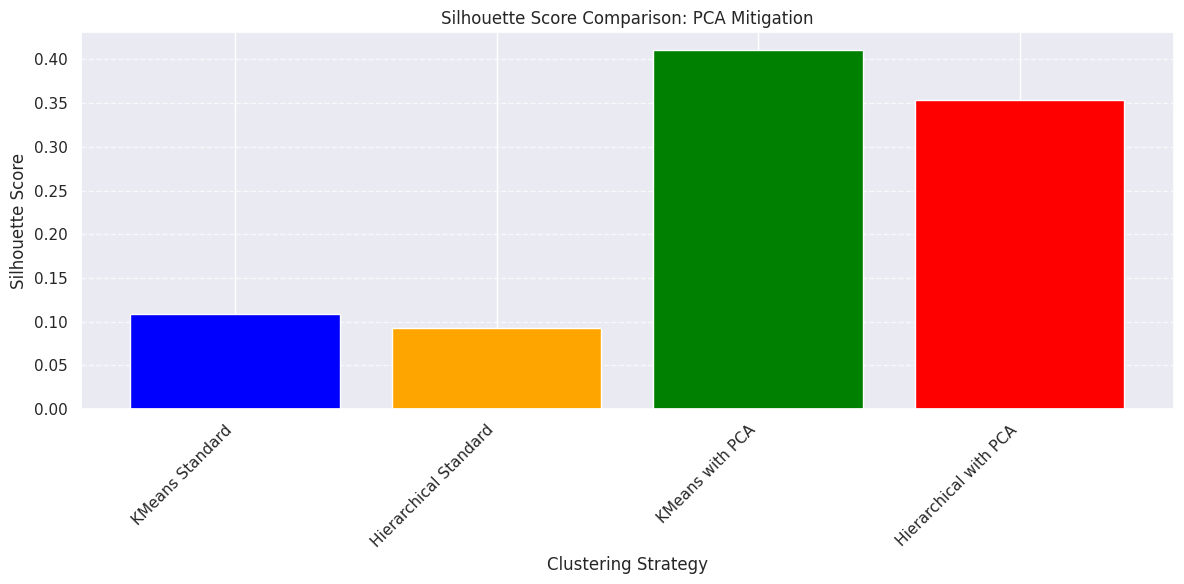

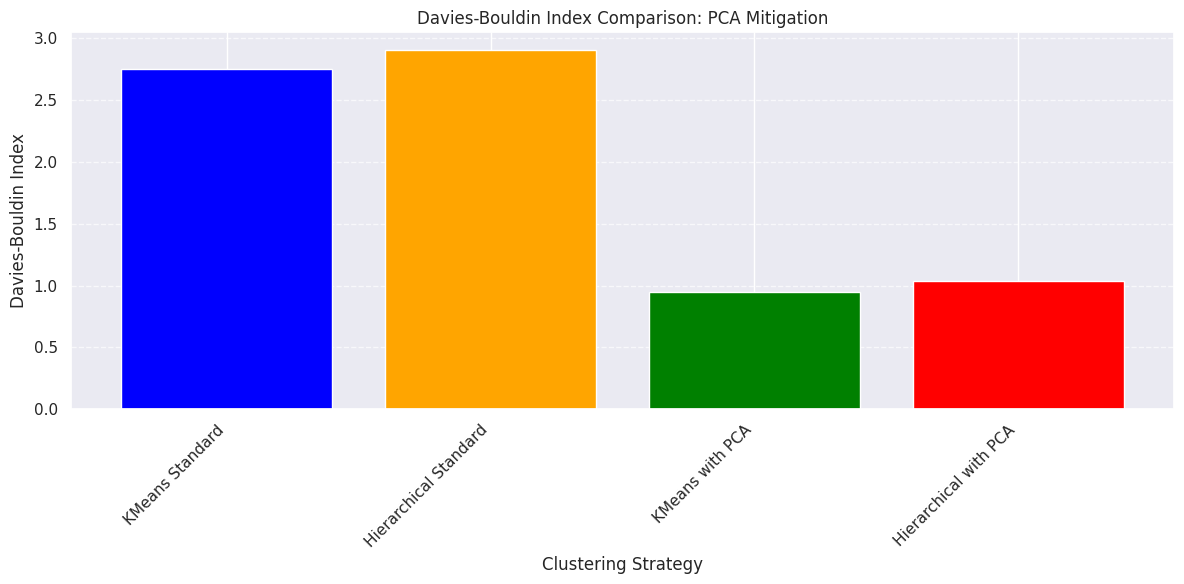

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Provided PCA Mitigation Strategy comparison data
silhouette_scores = {
    'KMeans Standard': 0.10922010206278132,
    'Hierarchical Standard': 0.09264680781751994,
    'KMeans with PCA': 0.41049440247806257,
    'Hierarchical with PCA': 0.35399652346184013,
}

davies_bouldin_indices = {
    'KMeans Standard': 2.7534047429737685,
    'Hierarchical Standard': 2.9041821733798168,
    'KMeans with PCA': 0.9511062088322325,
    'Hierarchical with PCA': 1.0406075243015342,
}

# Bar Graph 1: Silhouette Score Comparison
plt.figure(figsize=(12, 6))
plt.bar(silhouette_scores.keys(), silhouette_scores.values(), color=['blue', 'orange', 'green', 'red'])
plt.title('Silhouette Score Comparison: PCA Mitigation')
plt.ylabel('Silhouette Score')
plt.xlabel('Clustering Strategy')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Bar Graph 2: Davies-Bouldin Index Comparison
plt.figure(figsize=(12, 6))
plt.bar(davies_bouldin_indices.keys(), davies_bouldin_indices.values(), color=['blue', 'orange', 'green', 'red'])
plt.title('Davies-Bouldin Index Comparison: PCA Mitigation')
plt.ylabel('Davies-Bouldin Index')
plt.xlabel('Clustering Strategy')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
